In [1]:
import numpy as np
import scipy.linalg as la
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import rcParams
from TurbCurv import orr_sommerfeld
from TurbCurv import orr_sommerfeld_non_uniform, D_matrices_non_uniform
from scipy import integrate
import h5py
import cmath
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from findiff import FinDiff
from scipy.integrate import cumtrapz
%matplotlib inline
plt.rc('text',usetex=True)
plt.rc('font',family='serif')
rcParams.update({'figure.autolayout': True})

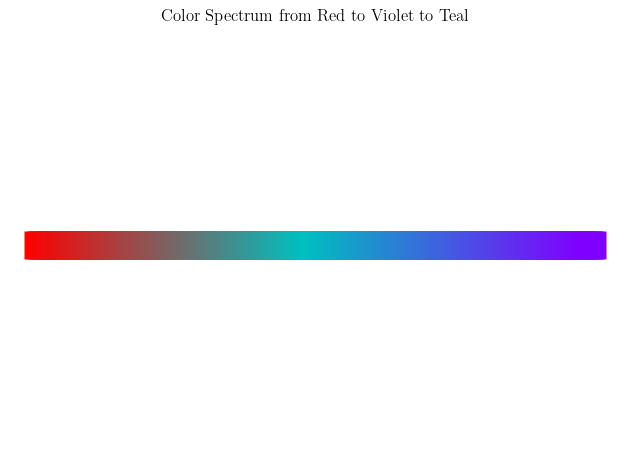

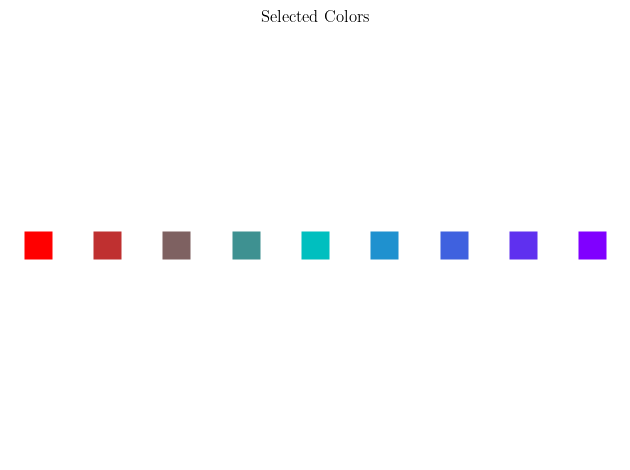

In [2]:
# Define the colors
color1 = np.array([1, 0, 0])  # red
color5 = np.array([0, 0.75, 0.75])  # teal
color9 = np.array([0.5, 0, 1])  # violet

# Number of intermediate colors
num_colors = 100

# Interpolate colors between color1 and color5
colors1_to_5 = np.linspace(color1, color5, num_colors)

# Interpolate colors between color5 and color9
colors5_to_9 = np.linspace(color5, color9, num_colors)

# Combine the colors to form a full spectrum
full_spectrum = np.vstack((colors1_to_5, colors5_to_9))

# Pick 9 colors evenly distributed across the spectrum
indices = np.round(np.linspace(0, full_spectrum.shape[0] - 1, 9)).astype(int)
selected_colors = full_spectrum[indices]

# Store the selected colors in a list
color_array = [list(selected_colors[i]) for i in range(9)]

# Plot the spectrum
plt.figure()
for i in range(full_spectrum.shape[0]):
    plt.plot(i, 1, 's', markersize=20, markeredgecolor='none', markerfacecolor=full_spectrum[i])
plt.axis('off')
plt.title('Color Spectrum from Red to Violet to Teal')
plt.show()

# Display the selected colors
plt.figure()
for i in range(9):
    plt.plot(i, 1, 's', markersize=20, markeredgecolor='none', markerfacecolor=selected_colors[i])
plt.axis('off')
plt.title('Selected Colors')
plt.show()


In [4]:
def mape(y_true, y_pred): 
    """
    Calculate Mean Absolute Percentage Error (MAPE)

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values

    Returns:
        float: MAPE value
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100



In [5]:
def ddxi_fft(f, x, kx):
    f_hat     = np.fft.fft(f)
    df_dx_hat = 1j*kx*f_hat
    df_dx     = np.real(np.fft.ifft(df_dx_hat))
    return df_dx

In [6]:
cd '/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv'

/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv


In [7]:
ls

Imp_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Imu_profile_WRLES_vs_Model.png
Imu_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Imw_profile_WRLES_vs_exp1_decay_Model_nuT.png
Imw_profile_WRLES_vs_exp1_decay_Model_nuT_VanDriest.png
Imw_profile_WRLES_vs_exp5_decay_Model_nuT.png
Imw_profile_WRLES_vs_exp5_decay_Model_nuT_VanDriest.png
Imw_profile_WRLES_vs_no_exp_decay_Model_nuT.png
Imw_profile_WRLES_vs_no_exp_decay_Model_nuT_VanDriest.png
Imw_profile_no_decay_vs_exp5_decay_Model_nuT_VanDriest.png
README.md
Rep_profile_WRLES_vs_Model.png
Rep_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Reu_profile_no_decay_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Rew_profile_WRLES_vs_exp1_decay_Model_nuT_LES.png
Rew_profile_WRLES_vs_exp1_decay_Model_nuT_LES_VanDriest.png
Rew_profile_WRLES_vs_exp5_decay_Model_nuT_LES.png
Rew_profile_WRLES_vs_exp5_decay_Model_nuT_LES_VanDriest.png
Rew_profile_WRLES_vs_no_exp_Model_nuT_LES.png
Rew_profile_WRLES_vs_no_exp_decay_Model_n

In [8]:
filename=['phase_averaged_data_all_10_c-25.mat', 
          'phase_averaged_data_all_09_c-15.mat', 
          'phase_averaged_data_all_08_c-7.mat', 
          'phase_averaged_data_all_07_c-2.mat', 
          'phase_averaged_data_all_06_c0.mat', 
          'phase_averaged_data_all_02_c2.mat', 
          'phase_averaged_data_all_03_c7.mat', 
          'phase_averaged_data_all_04_c15.mat',
          'phase_averaged_data_all_05_c25.mat',
          'phase_averaged_data_all_01_flat.mat'];

filename_TKE=['TKE_budget_terms_10_c-25.mat', 
              'TKE_budget_terms_09_c-15.mat', 
              'TKE_budget_terms_08_c-7.mat', 
              'TKE_budget_terms_07_c-2.mat', 
              'TKE_budget_terms_06_c0.mat', 
              'TKE_budget_terms_02_c2.mat', 
              'TKE_budget_terms_03_c7.mat', 
              'TKE_budget_terms_04_c15.mat',
              'TKE_budget_terms_05_c25.mat',
              'TKE_budget_terms_01_flat.mat'];


c_array=[-25,-15,-7,-2,0,2,7,15,25,0];
limited_c_array_index=[0,3,4,5,8]
num_data=np.size(c_array)
num_data

10

In [9]:
#### Read in profiles from mat files
sully_path='/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/data/phase_averaged_and_TKE_data/'

class profile_mat_data:
    def __init__(self,Filename):
        DATA=sio.loadmat(Filename)
        zi=1
        Nx=864;
        Ny=576;
        Nz=144;

        self.eta = DATA['eta_phase_avg']
        self.u_w_surf = DATA['u_w_phase_avg'][:,0]-np.mean(DATA['u_w_phase_avg'][:,0],axis=0)
        self.w_surf   = DATA['w_phase_avg'][:,0]-np.mean(DATA['w_phase_avg'][:,0],axis=0)
        self.w   = DATA['w_phase_avg'][:,:]-np.mean(DATA['w_phase_avg'][:,:],axis=0)
        self.w_phase_avg   = DATA['w_phase_avg'][:,:]
        self.w_mean = np.mean(DATA['w_phase_avg'],axis=0)

        self.u_w_t_avg_mean = np.mean(DATA['u_w_time_avg'][:,:],axis=0)
        self.v_w_t_avg_mean = np.mean(DATA['v_w_time_avg'][:,:],axis=0)
        self.w_t_avg_mean   = np.mean(DATA['w_time_avg'][:,:],axis=0)
  
        
        self.W   = DATA['W_phase_avg'][:,:]-np.mean(DATA['W_phase_avg'][:,:],axis=0)
        self.W_phase_avg = DATA['W_phase_avg'][:,:]
        self.W_mean = np.mean(DATA['W_phase_avg'],axis=0)
        
        self.u_w = DATA['u_w_phase_avg'][:,:]-np.mean(DATA['u_w_phase_avg'][:,:],axis=0)
        self.u_w_phase_avg = DATA['u_w_phase_avg'][:,:]
        self.v_w_phase_avg = DATA['v_w_phase_avg'][:,:]
        self.u_mean =  np.mean(DATA['u_w_phase_avg'],axis=0)
        self.v_mean =  np.mean(DATA['v_w_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.U = DATA['U_phase_avg'][:,:]-np.mean(DATA['U_phase_avg'][:,:],axis=0)
        self.U_phase_avg = DATA['U_phase_avg'][:,:]
        self.U_mean   = np.mean(DATA['U_phase_avg'],axis=0)
        
        self.uU_phase_avg = DATA['uU_phase_avg'][:,:]
        self.vU_phase_avg = DATA['vU_phase_avg'][:,:]
        self.wU_phase_avg = DATA['wU_phase_avg'][:,:]

        self.uW_phase_avg = DATA['uW_phase_avg'][:,:]
        self.vW_phase_avg = DATA['vW_phase_avg'][:,:]
        self.wW_phase_avg = DATA['wW_phase_avg'][:,:]
        
        self.uiuiU_phase_avg = DATA['uiuiU_phase_avg'][:,:]
        self.uiuiW_phase_avg = DATA['uiuiW_phase_avg'][:,:]
        
        self.uu_w_phase_avg  = DATA['uu_w_phase_avg'][:,:]
        self.vv_w_phase_avg  = DATA['vv_w_phase_avg'][:,:]
        self.ww_phase_avg    = DATA['ww_phase_avg'][:,:]

        self.upup_phase_avg  = DATA['uu_w_phase_avg'][:,:] - DATA['u_w_phase_avg'][:,:]*DATA['u_w_phase_avg'][:,:]
        self.vpvp_phase_avg  = DATA['vv_w_phase_avg'][:,:] - DATA['v_w_phase_avg'][:,:]*DATA['v_w_phase_avg'][:,:]
        self.wpwp_phase_avg  =   DATA['ww_phase_avg'][:,:] -   DATA['w_phase_avg'][:,:]*DATA['w_phase_avg'][:,:]

        self.upwp_phase_avg  = DATA['uw_phase_avg'][:,:] - DATA['u_w_phase_avg'][:,:]*DATA['w_phase_avg'][:,:]
        self.vpwp_phase_avg  = DATA['vw_phase_avg'][:,:] - DATA['v_w_phase_avg'][:,:]*DATA['w_phase_avg'][:,:]
        self.upvp_phase_avg  = DATA['uv_phase_avg'][:,:] - DATA['u_w_phase_avg'][:,:]*DATA['v_w_phase_avg'][:,:]

        self.upup_d_phase_avg=self.upup_phase_avg - (1/3)*(self.upup_phase_avg + self.vpvp_phase_avg + self.wpwp_phase_avg)
        self.vpvp_d_phase_avg=self.vpvp_phase_avg - (1/3)*(self.upup_phase_avg + self.vpvp_phase_avg + self.wpwp_phase_avg)
        self.wpwp_d_phase_avg=self.wpwp_phase_avg - (1/3)*(self.upup_phase_avg + self.vpvp_phase_avg + self.wpwp_phase_avg)
        
        

        self.zw=DATA['zw']*zi
        
        ##############################################################################################################
        
        self.tau13        = (DATA['tau13_phase_avg']-np.mean(DATA['tau13_phase_avg'][:,:],axis=0))
        self.tau13_mean   = np.mean(DATA['tau13_phase_avg'],axis=0)
        
        self.tau13_SGS      = (DATA['tau13_SGS_phase_avg']-np.mean(DATA['tau13_SGS_phase_avg'][:,:],axis=0))
        self.tau13_SGS_mean = np.mean(DATA['tau13_SGS_phase_avg'],axis=0)
        
        self.tau13_nu       = (DATA['tau13_nu_phase_avg']-np.mean(DATA['tau13_nu_phase_avg'][:,:],axis=0))
        self.tau13_nu_mean  = np.mean(DATA['tau13_nu_phase_avg'],axis=0)

        self.tau23_nu       = (DATA['tau23_nu_phase_avg']-np.mean(DATA['tau23_nu_phase_avg'][:,:],axis=0))
        self.tau23_nu_mean  = np.mean(DATA['tau23_nu_phase_avg'],axis=0)

        self.tau23_SGS       = (DATA['tau23_SGS_phase_avg']-np.mean(DATA['tau23_SGS_phase_avg'][:,:],axis=0))
        self.tau23_SGS_mean  = np.mean(DATA['tau23_SGS_phase_avg'],axis=0)

        self.tau13_wave      = ((DATA['tau13_wave_phase_avg']-np.mean(DATA['tau13_wave_phase_avg'][:,:],axis=0)))
        self.tau13_wave_mean = np.mean(DATA['tau13_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau31        = (DATA['tau31_phase_avg']-np.mean(DATA['tau31_phase_avg'][:,:],axis=0))
        self.tau31_mean   = np.mean(DATA['tau31_phase_avg'],axis=0)
        
        self.tau31_SGS      = (DATA['tau31_SGS_phase_avg']-np.mean(DATA['tau31_SGS_phase_avg'][:,:],axis=0))
        self.tau31_SGS_mean = np.mean(DATA['tau31_SGS_phase_avg'],axis=0)
        
        self.tau31_nu       = (DATA['tau31_nu_phase_avg']-np.mean(DATA['tau31_nu_phase_avg'][:,:],axis=0))
        self.tau31_nu_mean  = np.mean(DATA['tau31_nu_phase_avg'],axis=0)

        self.tau31_wave       = (DATA['tau31_wave_phase_avg']-np.mean(DATA['tau31_wave_phase_avg'][:,:],axis=0))
        self.tau31_wave_mean  = np.mean(DATA['tau31_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau11       = (DATA['tau11_phase_avg']-np.mean(DATA['tau11_phase_avg'][:,:],axis=0))
        self.tau11_mean  = np.mean(DATA['tau11_phase_avg'],axis=0)
        
        self.tau11_SGS      = (DATA['tau11_SGS_phase_avg']-np.mean(DATA['tau11_SGS_phase_avg'][:,:],axis=0))
        self.tau11_SGS_mean = np.mean(DATA['tau11_SGS_phase_avg'],axis=0)
        
        self.tau11_nu      = (DATA['tau11_nu_phase_avg']-np.mean(DATA['tau11_nu_phase_avg'][:,:],axis=0))
        self.tau11_nu_mean = np.mean(DATA['tau11_nu_phase_avg'],axis=0)
      
        self.tau21_nu      = (DATA['tau21_nu_phase_avg']-np.mean(DATA['tau21_nu_phase_avg'][:,:],axis=0))
        self.tau21_nu_mean = np.mean(DATA['tau21_nu_phase_avg'],axis=0)
      
        self.tau21_SGS      = (DATA['tau21_SGS_phase_avg']-np.mean(DATA['tau21_SGS_phase_avg'][:,:],axis=0))
        self.tau21_SGS_mean = np.mean(DATA['tau21_SGS_phase_avg'],axis=0)
        
        self.tau11_wave       = (DATA['tau11_wave_phase_avg']-np.mean(DATA['tau11_wave_phase_avg'][:,:],axis=0))
        self.tau11_wave_mean  = np.mean(DATA['tau11_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau33      = (DATA['tau33_phase_avg']-np.mean(DATA['tau33_phase_avg'][:,:],axis=0))
        self.tau33_mean = np.mean(DATA['tau33_phase_avg'],axis=0)
        
        self.tau33_SGS      = (DATA['tau33_SGS_phase_avg']-np.mean(DATA['tau33_SGS_phase_avg'][:,:],axis=0))
        self.tau33_SGS_mean = np.mean(DATA['tau33_SGS_phase_avg'],axis=0)
        
        self.tau33_nu      = (DATA['tau33_nu_phase_avg']-np.mean(DATA['tau33_nu_phase_avg'][:,:],axis=0))
        self.tau33_nu_mean = np.mean(DATA['tau33_nu_phase_avg'],axis=0)
        
        self.tau33_wave      = (DATA['tau33_wave_phase_avg']-np.mean(DATA['tau33_wave_phase_avg'][:,:],axis=0))
        self.tau33_wave_mean = np.mean(DATA['tau33_wave_phase_avg'],axis=0)
        
        ##############################################################################################################
        
        self.tau11_d = self.tau11 - (1/3)*(self.tau11+self.tau33)
        self.tau33_d = self.tau33 - (1/3)*(self.tau11+self.tau33)
        self.tau11_d_SGS  = self.tau11_SGS  - (1/3)*(self.tau11_SGS  + self.tau33_SGS)
        self.tau33_d_SGS  = self.tau33_SGS  - (1/3)*(self.tau11_SGS  + self.tau33_SGS)
        self.tau11_d_wave = self.tau11_wave - (1/3)*(self.tau11_wave + self.tau33_wave)
        self.tau33_d_wave = self.tau33_wave - (1/3)*(self.tau11_wave + self.tau33_wave)
        self.tau11_d_nu   = self.tau11_nu  - (1/3)*(self.tau11_nu  + self.tau33_nu)
        self.tau33_d_nu   = self.tau33_nu  - (1/3)*(self.tau11_nu  + self.tau33_nu)

        self.p_w_tilde =         DATA['p_w_phase_avg'][:,:] - np.mean(DATA['p_w_phase_avg'][:,:],axis=0)
        
        self.p_w       =         (DATA['p_w_phase_avg'][:,:] + (1/3)*(self.tau11+self.tau33) + (1/3)*(self.tau11_SGS  + self.tau33_SGS)) \
                         -np.mean(DATA['p_w_phase_avg'][:,:] + (1/3)*(self.tau11+self.tau33) + (1/3)*(self.tau11_SGS  + self.tau33_SGS),axis=0)
        self.p_w_surf  = self.p_w[:,0]  # DATA['p_w_phase_avg'][:,0]-np.mean(DATA['p_w_phase_avg'][:,0],axis=0)
        
        ##############################################################################################################
        
        self.taup_13      = (DATA['taup_13_phase_avg']-np.mean(DATA['taup_13_phase_avg'][:,:],axis=0))
        self.taup_13_mean = np.mean(DATA['taup_13_phase_avg'],axis=0)
        
        self.taup_11      = (DATA['taup_11_phase_avg']-np.mean(DATA['taup_11_phase_avg'][:,:],axis=0))
        self.taup_11_mean = np.mean(DATA['taup_11_phase_avg'],axis=0)

        self.taup_33      = DATA['p_w_phase_avg'][:,:]-np.mean(DATA['p_w_phase_avg'][:,:],axis=0)
        self.taup_33_mean = np.mean(DATA['p_w_phase_avg'][:,:],axis=0)

        ##############################################################################################################
        
#         tau13_wave_xz = np.zeros([Nx, Nz], dtype='float64')
#         for k in range(Nz):
#             tau13_wave_xz[:, k] = -(
#                 DATA['u_w_phase_avg'][:, k] - np.mean(DATA['u_w_phase_avg'][:, k], axis=0)
#             ) * (
#                 DATA['W_phase_avg'][:, k] - np.mean(DATA['W_phase_avg'][:, k], axis=0)
#             )

#         self.tau13_wave = np.mean(tau13_wave_xz[:,:],axis=0)
#         self.tau13_wave_contour = tau13_wave_xz[:,:]
        ##############################################################################################################
        
        self.tau_tot  = self.tau13+self.tau13_SGS+self.tau13_nu+self.taup_13+self.tau13_wave
        self.tau_tot_mean  = self.tau13_mean+self.tau13_SGS_mean+self.tau13_nu_mean+self.taup_13_mean+self.tau13_wave_mean


        ####################################################################################################################

        
        
LES_data =[[],[],[],[],[],[],[],[],[],[]]
for n in range(num_data):
    LES_data[n]=profile_mat_data(sully_path+filename[n])
    print(LES_data[n])

In [10]:
class TKE_profile_mat_data:
    def __init__(self,Filename):
        DATA=sio.loadmat(Filename)
        zi=1
        Nx=864;
        Ny=576;
        Nz=144;

        self.TKE = DATA['TKE']
        self.epsilon_TKE = DATA['epsilon_phase_avg']
        self.epsilon_J_TKE = DATA['epsilon_J_phase_avg']
        
        self.epsilon_SGS_TKE = DATA['epsilon_SGS_phase_avg']
        self.uiuiU_TKE   = DATA['uiuiU_TKE']
        self.uiuiW_TKE   = DATA['uiuiW_TKE']
        self.upi_taup_SGS_i1_TKE = DATA['upi_taup_SGS_i1_TKE']
        self.upi_taup_SGS_i3_TKE = DATA['upi_taup_SGS_i3_TKE']
        self.upi_taup_nu_i1_TKE = DATA['upi_taup_nu_i1_TKE']
        self.upi_taup_nu_i3_TKE = DATA['upi_taup_nu_i3_TKE']
        self.pp_Up_TKE = DATA['pp_Up_TKE']
        self.pp_Wp_TKE = DATA['pp_Wp_TKE']
        
LES_TKE_data =[[],[],[],[],[],[],[],[],[],[]]
for n in range(num_data):
    LES_TKE_data[n]=TKE_profile_mat_data(sully_path+filename_TKE[n])
    print(LES_TKE_data[n])  

In [11]:
# Problem Parameters
N = 1024*2
ak=0.1
k_wavno=4
k=4
a=ak/k# in meters 
Retau=1000
nu=1/Retau
ustar=1
kappa=0.41;

pex=0.25;
pey=0.5;
pez=1;
Lx=2*np.pi/pex;
Ly=2*np.pi/pey;
Lz=1;
zi=Lz;
Hbar=Lz;

Nx=864;
Ny=576;
Nz=144;
x_LES=np.linspace(0,Lx,Nx)
kx=np.fft.fftfreq(Nx,d = 1/(Nx*pex))

use_non_uniform_grid=1;
#Tanh-stretched grid
z_min = 1e-6  # Minimum value in the physical domain
z_max = 1.0  # Maximum value in the physical domain
alpha = 5.0  # Stretching factor (adjust for more/less stretching)

# Create a linearly spaced grid in the range [0, 1]
eta = np.linspace(-1, 1, N)

# Apply the tanh stretching
z_stretched = 0.5 * (np.tanh(alpha * eta) + 1)

# Map the stretched grid to the desired physical domain
z_non_uniform = z_min + z_stretched * (z_max - z_min)
#z_non_uniform = np.logspace(np.log10(1e-6),np.log10(zi), N)

#Uniform grid
z_uniform = np.linspace(0,zi, N)


In [12]:
select_all_model=1
if select_all_model==1:
        n_num_array_index  =[0,1,2,3,4,5]
        color_array_plot   =['b-','r--','g-.','m:','y-.','y:'];
        color_array_plot_Re=['b-','r--','g-.','m:','y-.','y:'];
        color_array_plot_Im=['b-','r--','g-.','m:','y-.','y:'];
else:
        n_num_array_index  =[0,1,4,5]
        color_array_plot   =['b-','r--','g-.','m:','g-.','m:'];
        color_array_plot_Re=['b-','r--','g-.','m:','g-.','m:'];
        color_array_plot_Im=['b-','r--','g-.','m:','g-.','m:'];

0
0 -25


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.23582e-42): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=8.19633e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=2.69272e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


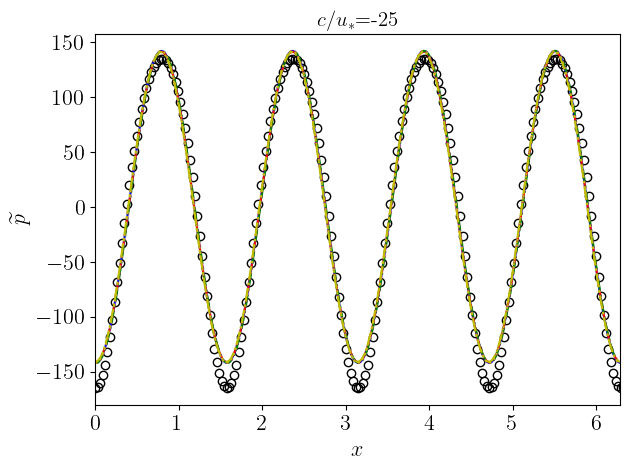

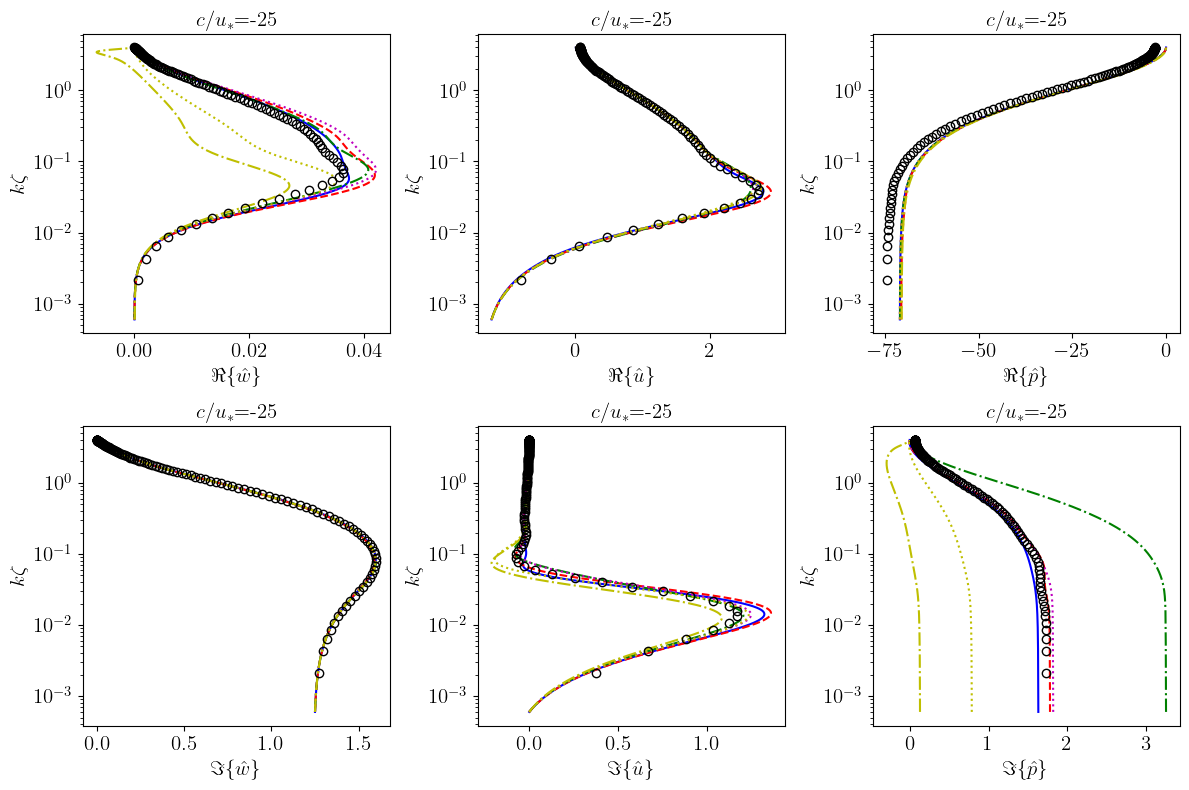

1
1 -15


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=2.0311e-42): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.49641e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=4.2337e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


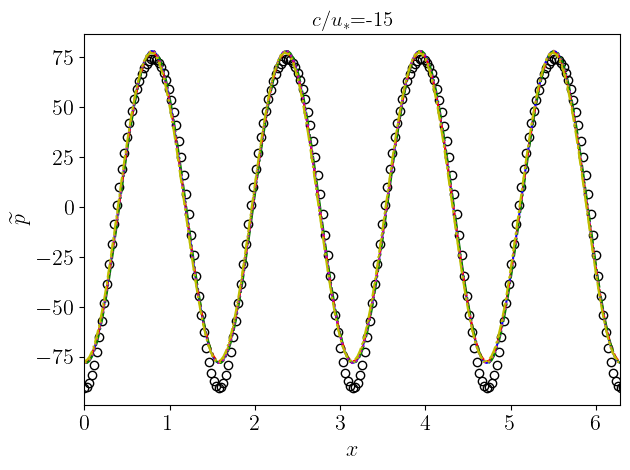

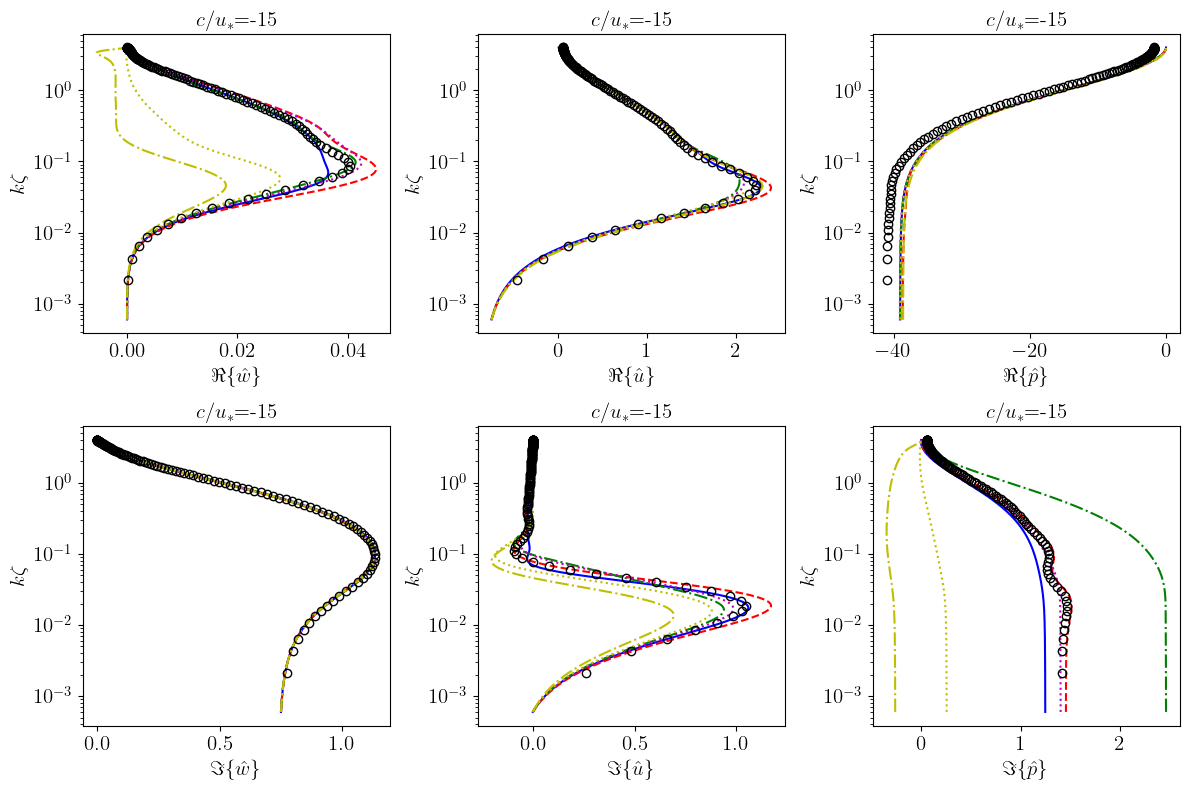

2
2 -7


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=7.13517e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=4.06276e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=7.27004e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


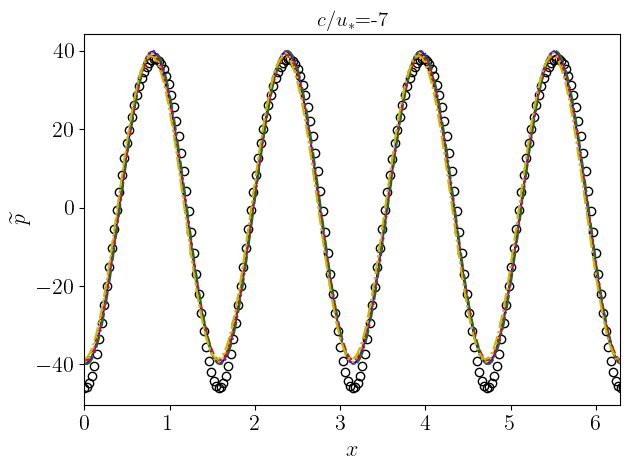

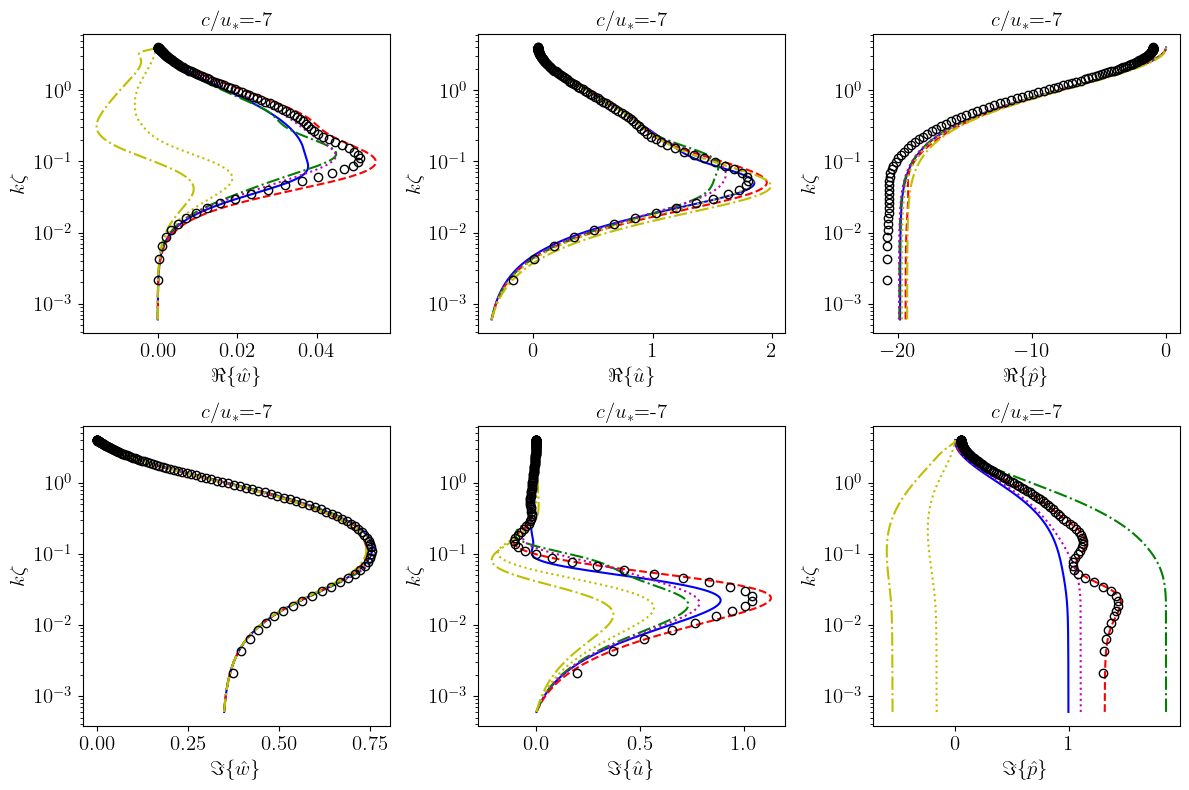

3
3 -2


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=6.69314e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.89591e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=8.98921e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


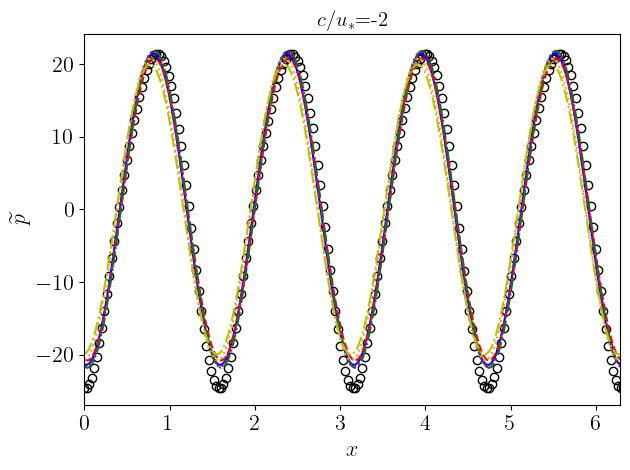

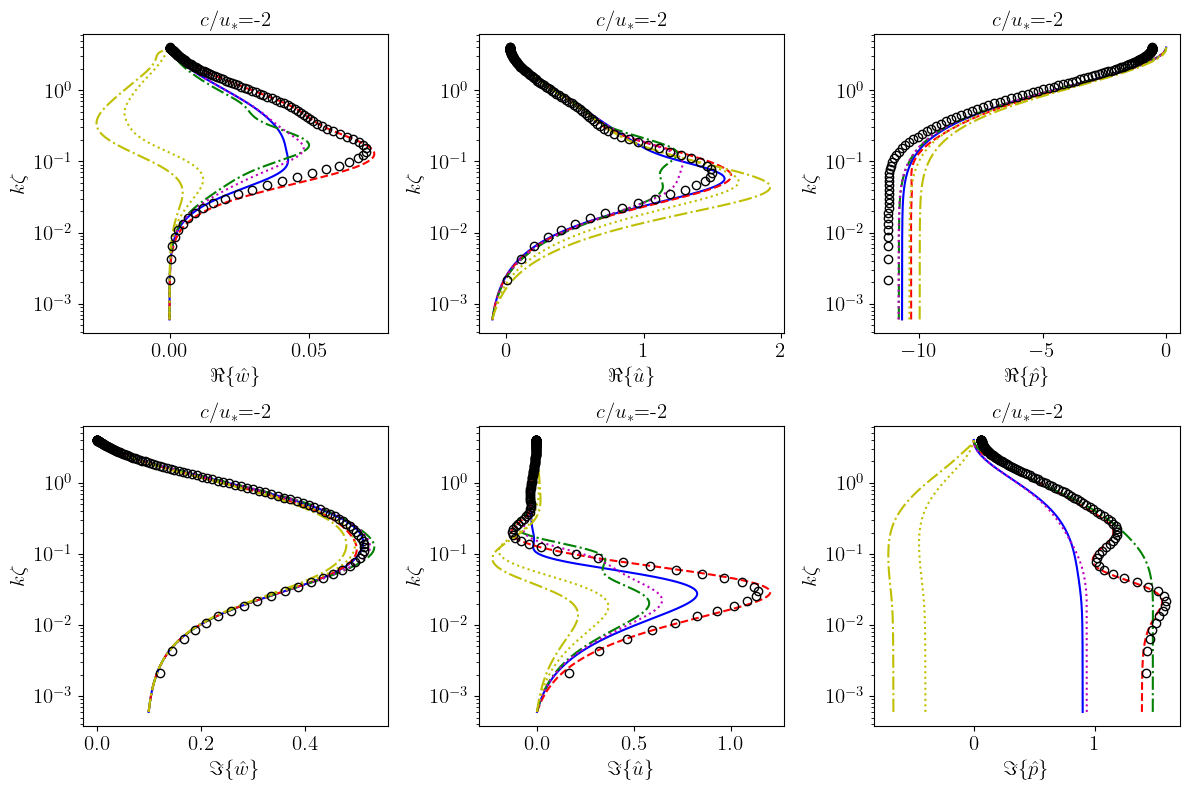

4
4 0


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=7.90996e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.99182e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=2.29993e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


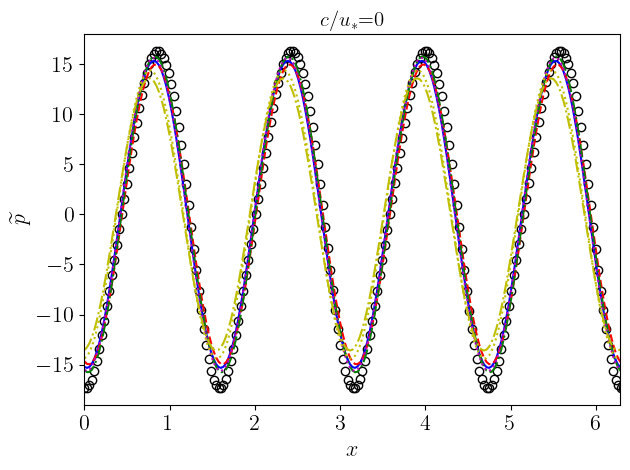

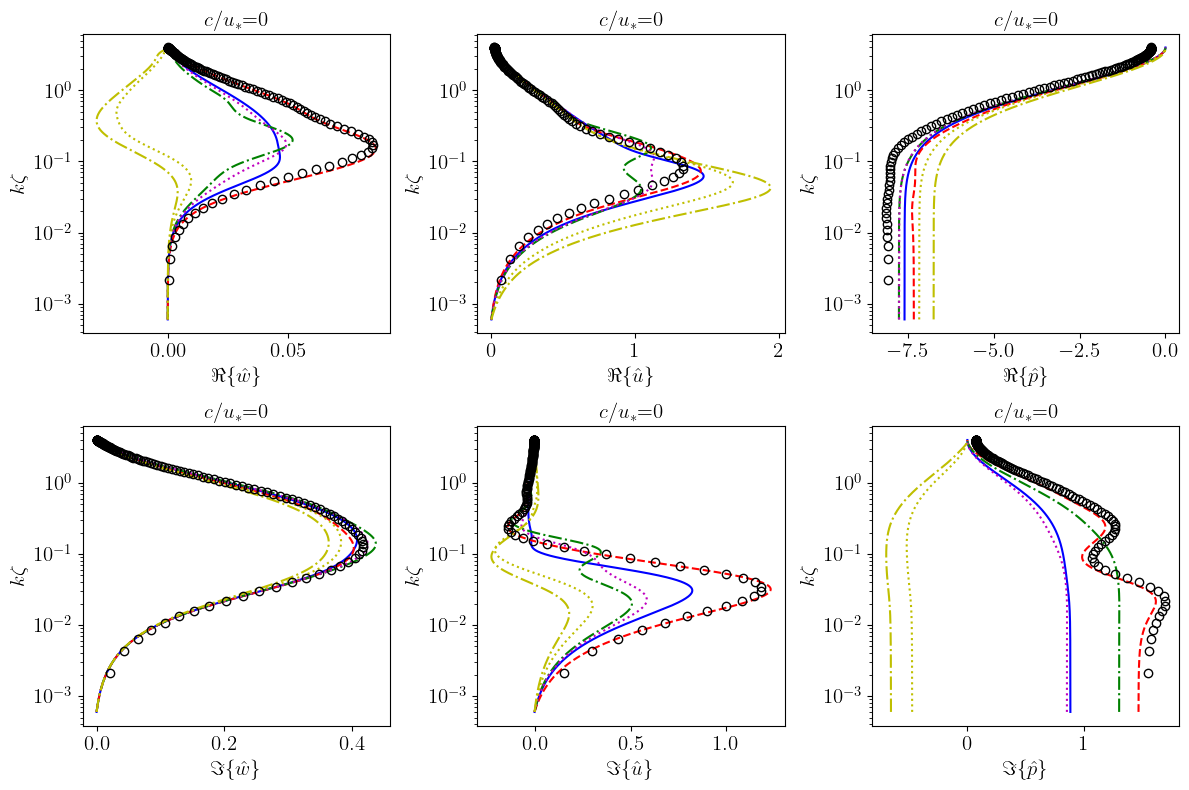

5
5 2


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=2.33189e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=5.58652e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=3.02225e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


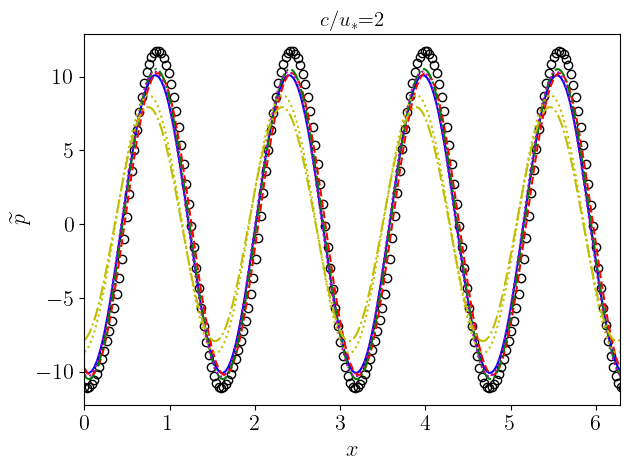

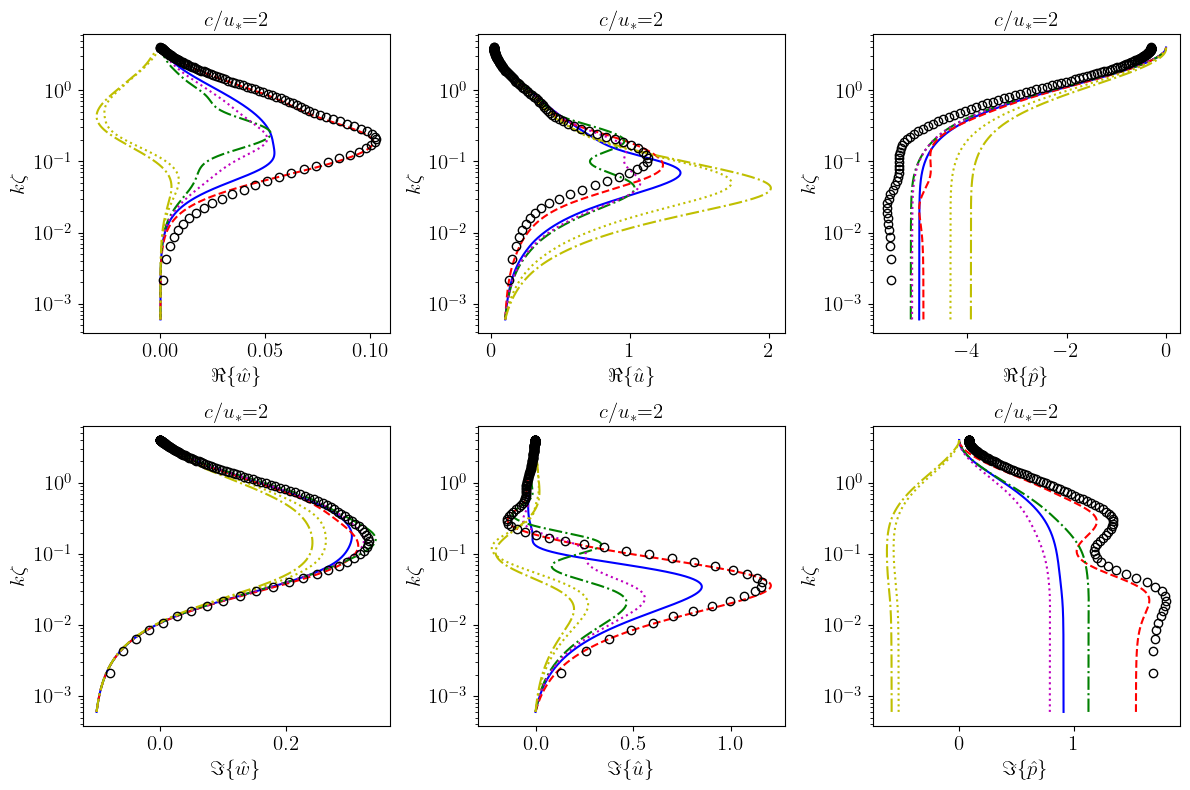

6
6 7


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=3.42794e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.36587e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=9.61718e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


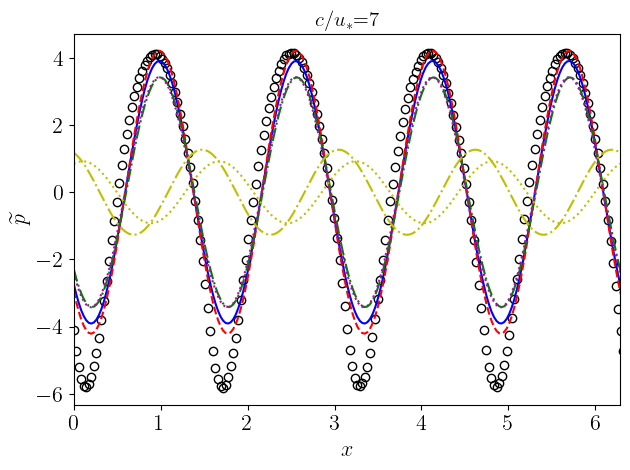

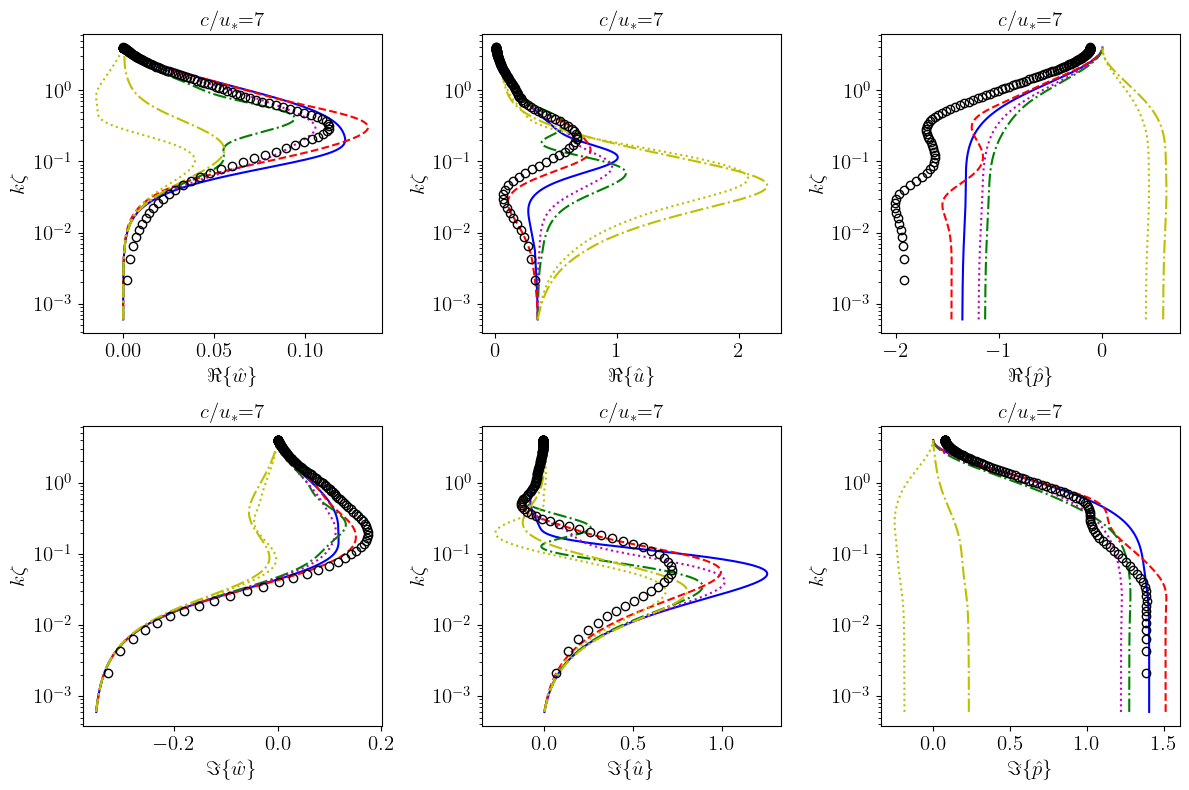

7
7 15


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=7.38256e-43): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=5.55759e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=7.27868e-43): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


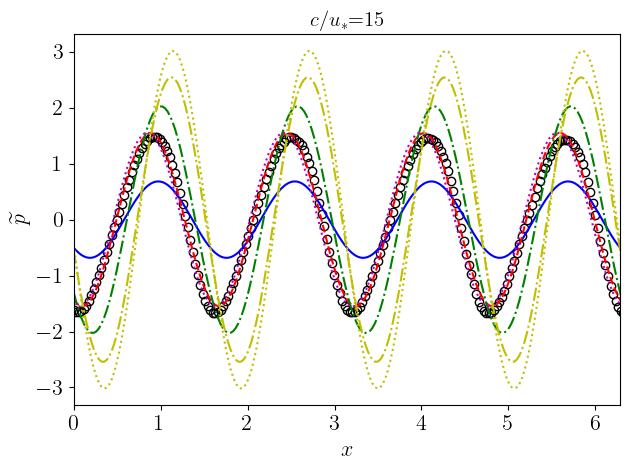

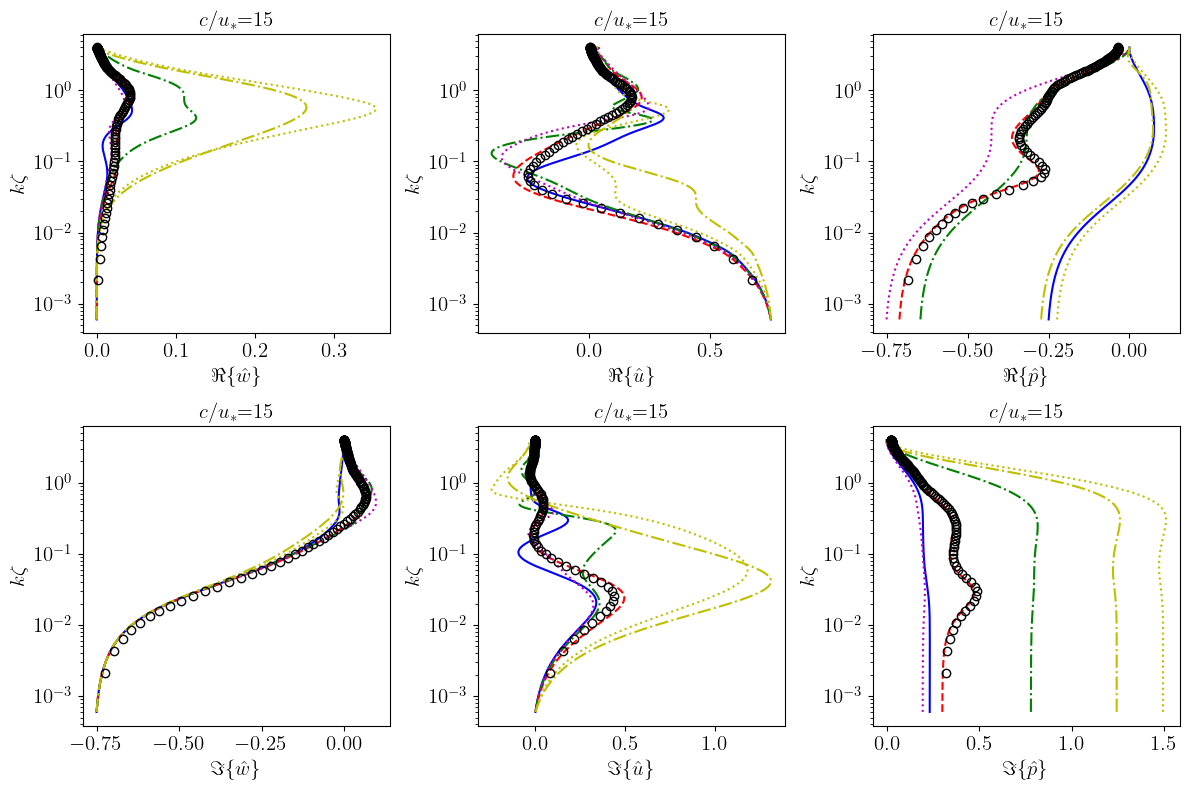

8
8 25


/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.84668e-44): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.09465e-48): result may not be accurate.
  w = la.solve(A, b)
/Users/ghaneshnarasimhan/Desktop/UMN/Bounday-Fitted-Code/WOW_visc-curv-model/TurbCurv-main/Github/TurbCurv/TurbCurv.py:168: LinAlgWarning: Ill-conditioned matrix (rcond=7.66052e-45): result may not be accurate.
  w = la.solve(A, b)


n,N 0 2048
n,N 1 2048
n,N 2 2048
n,N 3 2048
n,N 4 2048
n,N 5 2048


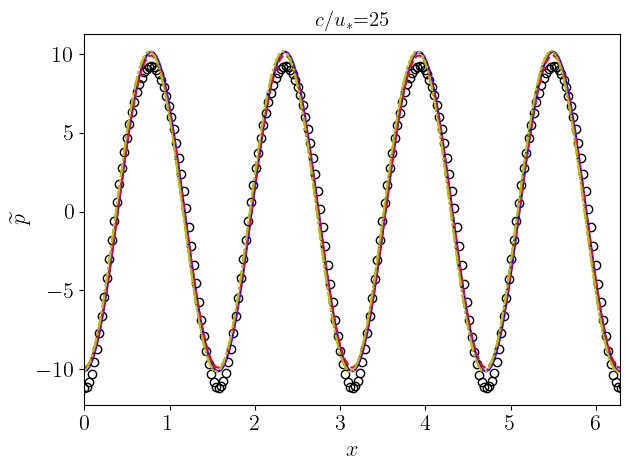

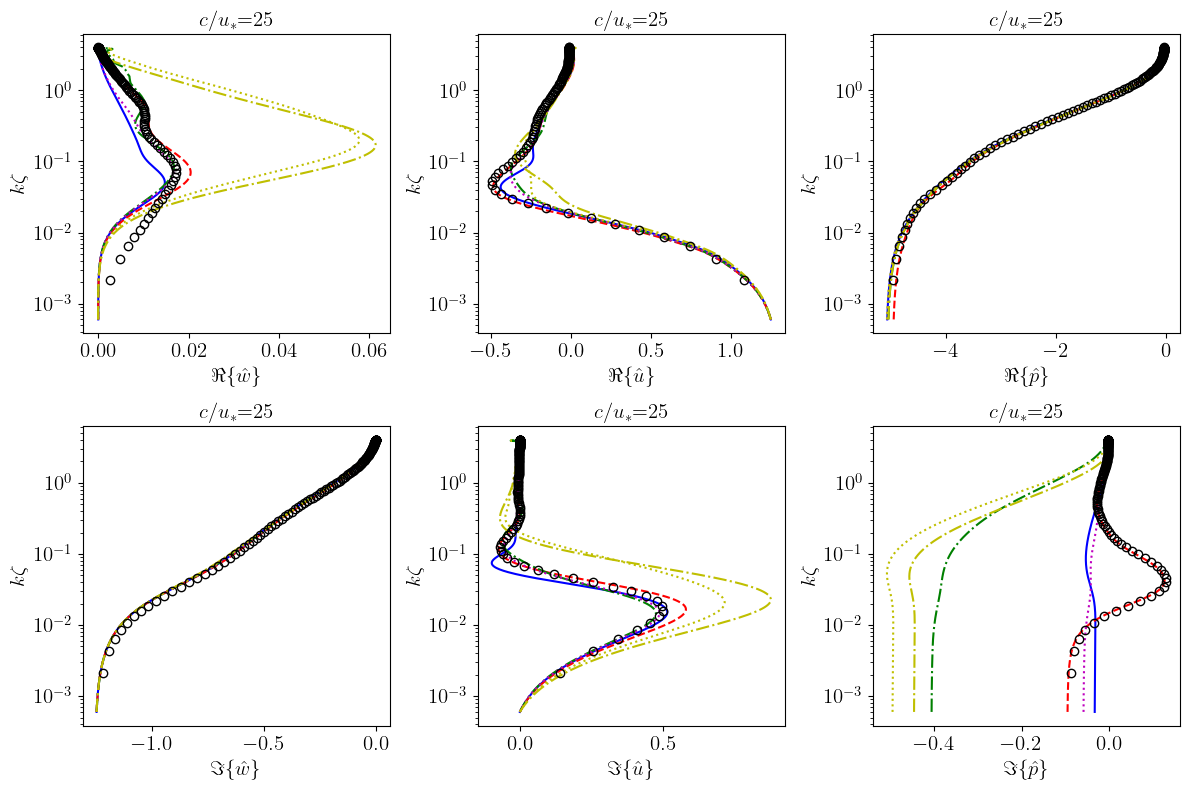

In [13]:
n_num=6;
w     = np.zeros((N,n_num,9),dtype=complex)
Rew   = np.zeros((N,n_num,9),dtype=complex)
Imw   = np.zeros((N,n_num,9),dtype=complex)
DRew  = np.zeros((N,n_num,9),dtype=complex)
DImw  = np.zeros((N,n_num,9),dtype=complex)
D2Rew = np.zeros((N,n_num,9),dtype=complex)
D2Imw = np.zeros((N,n_num,9),dtype=complex)
Reu   = np.zeros((N,n_num,9),dtype=complex)
Imu   = np.zeros((N,n_num,9),dtype=complex)
U     = np.zeros((N,n_num,9),dtype=complex)
U_prime        = np.zeros((N,n_num,9),dtype=complex)
U_double_prime = np.zeros((N,n_num,9),dtype=complex)
U_triple_prime = np.zeros((N,n_num,9),dtype=complex)

x = np.linspace(0,Lx,Nx)
y = a*np.cos(k_wavno*x)

Rep = np.zeros((N,4,n_num,9),dtype=complex)
Imp = np.zeros((N,4,n_num,9),dtype=complex)

for num_data_select in range(9):
    print(num_data_select)
    c=c_array[num_data_select] # in meter per second
    print(num_data_select,c)
    filename_fig = [
        '01_SurfacePressure_ComparisonWithLES_case0.png',
        '01_SurfacePressure_ComparisonWithLES_case1.png',
        '01_SurfacePressure_ComparisonWithLES_case2.png',
        '01_SurfacePressure_ComparisonWithLES_case3.png',
        '01_SurfacePressure_ComparisonWithLES_case4.png',
        '01_SurfacePressure_ComparisonWithLES_case5.png',
        '01_SurfacePressure_ComparisonWithLES_case6.png',
        '01_SurfacePressure_ComparisonWithLES_case7.png',
        '01_SurfacePressure_ComparisonWithLES_case8.png'
    ]
    if num_data_select<7:
        z0=3.0e-4/2
    else:
        z0=1.5e-4
        
        #z0=1.75e-4 #case-8

    #Log-law model
    if use_non_uniform_grid:
        
        #Tanh-stretched grid
        z_min = z0  # Minimum value in the physical domain
        z_max = 1.0  # Maximum value in the physical domain
        alpha = 8.0  # Stretching factor (adjust for more/less stretching)

        # Create a linearly spaced grid in the range [0, 1]
        eta = np.linspace(-1, 1, N)

        # Apply the tanh stretching
        z_stretched = 0.5 * (np.tanh(alpha * eta) + 1)

        # Map the stretched grid to the desired physical domain
        z_non_uniform = z_min + z_stretched * (z_max - z_min)

        #z_non_uniform = np.logspace(np.log10(z0),np.log10(zi), N)
        z = z_non_uniform #np.logspace(np.log10(z0),np.log10(zi), N)
    else:
        z_uniform = np.linspace(z0,zi, N)
        z = z_uniform     #np.linspace(z0,zi, N)
    ###########################################################################################################################################################
    
    #Input from LES for viscous Curvilinear model
    z_data = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data = np.asarray(LES_data[num_data_select].u_mean).flatten()
    
    
    U_spline = CubicSpline(z_data[0:-1],U_data[0:-1])
    U_visc = U_spline(z)
    
    U_prime_LES    = U_spline.derivative(nu=1)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_prime_spline = CubicSpline(z_data[0:-1],U_prime_LES)
    U_prime_visc   = U_prime_spline(z)
    
    
    U_double_prime_LES    = U_spline.derivative(nu=2)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_double_prime_spline = CubicSpline(z_data[0:-1],U_double_prime_LES)
    U_double_prime_visc   = U_double_prime_spline(z)
    
    U_triple_prime_LES    = U_spline.derivative(nu=3)(z_data[0:-1])#np.gradient(U,z,edge_order=2)
    U_triple_prime_spline = CubicSpline(z_data[0:-1],U_triple_prime_LES)
    U_triple_prime_visc   = U_triple_prime_spline(z)
    
    for n in range(n_num):
        U[:,n,num_data_select]       = U_visc
        U_prime[:,n,num_data_select] = U_prime_visc
        U_double_prime[:,n,num_data_select] = U_double_prime_visc
        U_triple_prime[:,n,num_data_select] = U_triple_prime_visc

    ##########################################################################################################################################
    w_hat_LES = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    dudz_hat_LES = np.gradient(u_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    dwdz_hat_LES = np.gradient(w_hat_LES[16,0:-1],z_data[0:-1],edge_order=2)
    tau13_mean_tot_LES = (LES_data[num_data_select].tau13_wave_mean[0:-1]*0+LES_data[num_data_select].tau13_mean[0:-1]+LES_data[num_data_select].tau13_SGS_mean[0:-1]).flatten()
    tau31_mean_tot_LES = (LES_data[num_data_select].tau31_mean[0:-1]+LES_data[num_data_select].tau31_SGS_mean[0:-1]).flatten()

    #Viscous stress
    tau11_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_nu[:,0:-1],norm='forward')
    tau13_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau13_nu[:,0:-1],norm='forward')
    tau31_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau31_nu[:,0:-1],norm='forward')
    tau33_nu_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_nu[:,0:-1],norm='forward')
    
    tau11_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau11_nu_hat_LES[16,:])
    tau13_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau13_nu_hat_LES[16,:])
    tau31_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau31_nu_hat_LES[16,:])
    tau33_nu_hat_LES_spline = CubicSpline(z_data[0:-1],tau33_nu_hat_LES[16,:])
    
    dtau11_nu_hat_dz_LES_interp   = tau11_nu_hat_LES_spline.derivative(nu=1)(z)
    d2tau13_nu_hat_dz2_LES_interp = tau13_nu_hat_LES_spline.derivative(nu=2)(z)
    tau31_nu_hat_LES_interp       = tau31_nu_hat_LES_spline(z)
    dtau33_nu_hat_dz_LES_interp   = tau33_nu_hat_LES_spline.derivative(nu=1)(z)

    
    
    
    #nuT_linear = -tau13_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1])# from LES
    nuT_linear = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    nuT_linear_1_interp  = np.interp(z,z_data[0:-1],nuT_linear)
    nuT_prime_1  = np.gradient(nuT_linear,z_data[0:-1])
    nuT_prime_1_interp  = np.interp(z,z_data[0:-1],nuT_prime_1)
    nuT_double_prime_1  = np.gradient(nuT_prime_1,z_data[0:-1])    
    nuT_double_prime_1_interp   = np.interp(z,z_data[0:-1],nuT_double_prime_1)
    
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)

    #nuT_linear_2 = -tau31_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1]) # from LES
    
    nuT_linear_2 = ustar*kappa*z_data[0:-1]*(1-np.exp(-z_data[0:-1]*Retau/25))*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    nuT_linear_2_interp  = np.interp(z,z_data[0:-1],nuT_linear_2)

    nuT_prime_2  = np.gradient(nuT_linear_2,z_data[0:-1])
    nuT_prime_2_interp  = np.interp(z,z_data[0:-1],nuT_prime_2)


    nuT_double_prime_2  = np.gradient(nuT_prime_2,z_data[0:-1])    
    nuT_double_prime_2_interp   = np.interp(z,z_data[0:-1],nuT_double_prime_2)
    
    
    tau11_hat_model_2 = 2*nuT_linear_2*dwdz_hat_LES
    tau13_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) - nuT_linear_2*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,0:-1]) 
    tau33_hat_model_2 =   nuT_linear_2*(1j*k_wavno*u_hat_LES[16,0:-1]-dwdz_hat_LES)

    
    tau11_hat_model_spline = CubicSpline(z_data[0:-1],tau11_hat_model)
    tau13_hat_model_spline = CubicSpline(z_data[0:-1],tau13_hat_model)
    tau31_hat_model_spline = CubicSpline(z_data[0:-1],tau31_hat_model)
    tau33_hat_model_spline = CubicSpline(z_data[0:-1],tau33_hat_model)
    dtau11_hat_dz_model_interp   = tau11_hat_model_spline.derivative(nu=1)(z)
    d2tau13_hat_dz2_model_interp = tau13_hat_model_spline.derivative(nu=2)(z)
    tau31_hat_model_interp = tau31_hat_model_spline(z)
    dtau33_hat_dz_model_interp = tau33_hat_model_spline.derivative(nu=1)(z)

    tau11_hat_model_2_spline = CubicSpline(z_data[0:-1],tau11_hat_model_2)
    tau13_hat_model_2_spline = CubicSpline(z_data[0:-1],tau13_hat_model_2)
    tau31_hat_model_2_spline = CubicSpline(z_data[0:-1],tau31_hat_model_2)
    tau33_hat_model_2_spline = CubicSpline(z_data[0:-1],tau33_hat_model_2)
    dtau11_hat_dz_model_2_interp   = tau11_hat_model_2_spline.derivative(nu=1)(z)
    d2tau13_hat_dz2_model_2_interp = tau13_hat_model_2_spline.derivative(nu=2)(z)
    tau31_hat_model_2_interp = tau31_hat_model_2_spline(z)
    dtau33_hat_dz_model_2_interp = tau33_hat_model_2_spline.derivative(nu=1)(z)
    
    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11_d+LES_data[num_data_select].tau11_d_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13  +LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31  +LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33_d+LES_data[num_data_select].tau33_d_SGS,axis=0,norm='forward')
    
    tau11_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau11_wave,axis=0,norm='forward')
    tau13_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau13_wave,axis=0,norm='forward')
    tau31_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau31_wave,axis=0,norm='forward')
    tau33_wave_hat_LES= np.fft.fft(LES_data[num_data_select].tau33_wave,axis=0,norm='forward')

    tau11_hat_spline = CubicSpline(z_data[0:-1],tau11_hat_LES[16,0:-1])
    tau13_hat_spline = CubicSpline(z_data[0:-1],tau13_hat_LES[16,0:-1])
    tau31_hat_spline = CubicSpline(z_data[0:-1],tau31_hat_LES[16,0:-1])
    tau33_hat_spline = CubicSpline(z_data[0:-1],tau33_hat_LES[16,0:-1])
    
    tau11_wave_hat_spline = CubicSpline(z_data[0:-1],tau11_wave_hat_LES[16,0:-1])
    tau13_wave_hat_spline = CubicSpline(z_data[0:-1],tau13_wave_hat_LES[16,0:-1])
    tau31_wave_hat_spline = CubicSpline(z_data[0:-1],tau31_wave_hat_LES[16,0:-1])
    tau33_wave_hat_spline = CubicSpline(z_data[0:-1],tau33_wave_hat_LES[16,0:-1])
    
    tau11_hat_interp = tau11_hat_spline(z)
    tau13_hat_interp = tau13_hat_spline(z)
    tau31_hat_interp = tau31_hat_spline(z)
    tau33_hat_interp = tau33_hat_spline(z)
    
    tau11_wave_hat_interp = tau11_wave_hat_spline(z)
    tau13_wave_hat_interp = tau13_wave_hat_spline(z)
    tau31_wave_hat_interp = tau31_wave_hat_spline(z)
    tau33_wave_hat_interp = tau33_wave_hat_spline(z)
    
    dtau11_hat_dz_interp      = tau11_hat_spline.derivative(nu=1)(z)
    dtau11_wave_hat_dz_interp = tau11_wave_hat_spline.derivative(nu=1)(z)
    dtau33_hat_dz_interp      = tau33_hat_spline.derivative(nu=1)(z)
    dtau33_wave_hat_dz_interp = tau33_wave_hat_spline.derivative(nu=1)(z)
    
    d2tau13_hat_dz2_interp      = tau13_hat_spline.derivative(nu=2)(z)
    d2tau13_wave_hat_dz2_interp = tau13_wave_hat_spline.derivative(nu=1)(z)
    #########################################################################################################################################
    
    # Inhomogeneous term
    
    #g = lambda z, zi: z/zi -1
    g = z/zi-1
    g_zeta = 1/zi
    f_RHS  = np.zeros((N,n_num),dtype=complex)
    
    f_RHS[:,0] =  nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) 
          
    f_RHS[:,1] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                  +( 1j*k_wavno*dtau11_hat_dz_interp + d2tau13_hat_dz2_interp )\
                  +( k_wavno**2*tau31_hat_interp - 1j*k_wavno*dtau33_hat_dz_interp )
    
    #f_RHS[:,2] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
    #              +1j*k_wavno*(dtau11_hat_dz_interp+dtau11_wave_hat_dz_interp) + d2tau13_hat_dz2_interp + d2tau13_wave_hat_dz2_interp \
    #              +k**2*(tau31_wave_hat_interp+tau31_hat_interp) -1j*k_wavno*(dtau33_hat_dz_interp+dtau33_wave_hat_dz_interp)

    f_RHS[:,2] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +( 1j*k_wavno*dtau11_hat_dz_model_interp + d2tau13_hat_dz2_model_interp )\
                   +( k_wavno**2*tau31_hat_model_interp - 1j*k_wavno*dtau33_hat_dz_model_interp )
    
    f_RHS[:,3] =   nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +( 1j*k_wavno*dtau11_hat_dz_model_2_interp + d2tau13_hat_dz2_model_2_interp )\
                   +( k_wavno**2*tau31_hat_model_2_interp - 1j*k_wavno*dtau33_hat_dz_model_2_interp )

    f_RHS[:,4] =   (nu*1+nuT_linear_1_interp*1)*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +1*nuT_prime_1_interp*a/2*g*(2*U_triple_prime[:,0,num_data_select]-k_wavno**2*U_prime[:,0,num_data_select]) \
                   +1*nuT_prime_1_interp*a/2*g_zeta*2*U_double_prime[:,0,num_data_select] \
                   +1*nuT_double_prime_1_interp*g*a/2*U_double_prime[:,0,num_data_select]
    
    f_RHS[:,5] =   (nu*1+nuT_linear_2_interp*1)*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2) \
                   +1*nuT_prime_2_interp*a/2*g*(2*U_triple_prime[:,0,num_data_select]-k_wavno**2*U_prime[:,0,num_data_select]) \
                   +1*nuT_prime_2_interp*a/2*g_zeta*2*U_double_prime[:,0,num_data_select] \
                   +1*nuT_double_prime_2_interp*g*a/2*U_double_prime[:,0,num_data_select]
            
    #plt.semilogy(nu*a/2*np.gradient(np.gradient(g*U_double_prime[:,0,num_data_select],z,edge_order=2),z,edge_order=2),z)
    #plt.semilogy(f_RHS[:,0],z)
    plt.show()

    # Solve Orr-Sommerfeld equation
    
    if use_non_uniform_grid:
        ##Boundary conditions: [phi(-1), phi'(-1), phi(1), phi'(1)]
    
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,0,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]

        w[:,0,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu, np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float')  , k_wavno, U[:,0,num_data_select], c, U_double_prime[:,0,num_data_select], f_RHS[:,0],z_bc)
    
        ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c
       
        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,1,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,1,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu, np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float') , k_wavno, U[:,1,num_data_select], c, U_double_prime[:,1,num_data_select], f_RHS[:,1],z_bc)
        
        ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,2,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,2,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu, np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float')  , k_wavno, U[:,2,num_data_select], c, U_double_prime[:,2,num_data_select], f_RHS[:,2],z_bc)

    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,3,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,3,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu, np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float'), np.zeros((N,),dtype='float')  , k_wavno, U[:,3,num_data_select], c, U_double_prime[:,3,num_data_select], f_RHS[:,3],z_bc)
    
    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,4,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,4,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, nuT_linear_1_interp*1, nuT_prime_1_interp*1, nuT_double_prime_1_interp*1  , k_wavno, U[:,4,num_data_select], c, U_double_prime[:,4,num_data_select], f_RHS[:,4],z_bc)

    ######################################################################################################################################################################################
       
        w_s   = -1j*0.5*a*k_wavno*c

        dwdz_s= -1j*0.5*a*k_wavno**2*c-1j*0.5*a*k_wavno*(-1)*U_prime[0,4,num_data_select]

        z_bc  =  [w_s,dwdz_s,0.0, 0.0]
        
        w[:,5,num_data_select]    = orr_sommerfeld_non_uniform(N, z, nu*1, nuT_linear_2_interp*1, nuT_prime_2_interp*1, nuT_double_prime_2_interp*1  , k_wavno, U[:,4,num_data_select], c, U_double_prime[:,4,num_data_select], f_RHS[:,4],z_bc)
    
    else:
        print("Use non uniform grid")
       # w[:,0,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,0],z_bc_nu)
       # w[:,1,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,1],z_bc)
       # w[:,2,num_data_select]    = orr_sommerfeld(N, z, nu*1, nuT*0, nuT_prime*0, nuT_double_prime*0  , k_wavno, U_visc, c, U_double_prime_visc, f_RHS[:,2],z_bc)
        
    
    # Calculate Real and Imaginary parts of w perturbation
    for n in range(n_num):
        Rew[:,n,num_data_select]  = np.real(w[:,n,num_data_select])
        Imw[:,n,num_data_select]  = np.imag(w[:,n,num_data_select])
        DRew[:,n,num_data_select] = np.gradient(np.real(w[:,n,num_data_select]),z,edge_order=2)
        DImw[:,n,num_data_select] = np.gradient(np.imag(w[:,n,num_data_select]),z,edge_order=2)
        D2Rew[:,n,num_data_select]= np.gradient(DRew[:,n,num_data_select],z,edge_order=2)
        D2Imw[:,n,num_data_select]= np.gradient(DImw[:,n,num_data_select],z,edge_order=2)
        Reu[:,n,num_data_select]  = -(1/k_wavno)*DImw[:,n,num_data_select]-0.5*a*(-1)*U_prime[:,n,num_data_select]
        Imu[:,n,num_data_select]  =  (1/k_wavno)*DRew[:,n,num_data_select]
         
    #### Compute pressure
    g      = (z/zi-1)
    for n in range(n_num):
        print('n,N',n,N)
        for i in range(N):
            D2w_hat    =   D2Rew[i:,n,num_data_select]+1j*D2Imw[i:,n,num_data_select]
            p_hat_adv  =   np.trapz(1j*k_wavno*(U[i:,n,num_data_select]-c)*w[i:,n,num_data_select],z[i:])
            p_hat_visc =  -nu*np.trapz(-k_wavno**2*w[i:,n,num_data_select]+D2w_hat,z[i:])
            if n<2:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_interp[i:],z[i:])
            if n==2:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_model_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_model_interp[i:],z[i:])
            if n==3:
                p_hat_turb =  1j*k_wavno*np.trapz(tau31_hat_model_2_interp[i:],z[i:])+np.trapz(dtau33_hat_dz_model_2_interp[i:],z[i:])

            
            Rep[i,0,n,num_data_select]=  p_hat_adv.real
            Rep[i,1,n,num_data_select]=  p_hat_visc.real
            Rep[i,2,n,num_data_select]=  p_hat_turb.real
            
            if n==0:
                Rep[i,3,n,num_data_select]=  Rep[i,0,n,num_data_select]+Rep[i,1,n,num_data_select]*1+Rep[i,2,n,num_data_select]*0
            else:
                Rep[i,3,n,num_data_select]=  Rep[i,0,n,num_data_select]+Rep[i,1,n,num_data_select]*1+Rep[i,2,n,num_data_select]
                
            Imp[i,0,n,num_data_select]=  p_hat_adv.imag
            Imp[i,1,n,num_data_select]=  p_hat_visc.imag
            Imp[i,2,n,num_data_select]=  p_hat_turb.imag
            
            if n==0:
                Imp[i,3,n,num_data_select]=  Imp[i,0,n,num_data_select]+Imp[i,1,n,num_data_select]*1+Imp[i,2,n,num_data_select]*0
            else:
                Imp[i,3,n,num_data_select]=  Imp[i,0,n,num_data_select]+Imp[i,1,n,num_data_select]*1+Imp[i,2,n,num_data_select]
    # plot it
    # f, (a0, a1, a2, a3) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [10, 1, 10, 10]})
    fig, (a0) = plt.subplots(1, 1, gridspec_kw={'height_ratios': [5]})
        
    phase_diff=np.pi/2*0;
    a0.plot(x, LES_data[num_data_select].p_w_surf-np.mean(LES_data[num_data_select].p_w_surf),'ok',markerfacecolor='none',label='LES')
    
    for n in n_num_array_index:
        a0.plot(x, 2*Rep[0,3,n,num_data_select]*np.cos(k_wavno*x+phase_diff)*1-1*2*Imp[0,3,n,num_data_select]*np.sin(k_wavno*x+phase_diff),color_array_plot[n],label=r'$2Re\{\hat{p}\}\cos (k\xi)-2Im\{\hat{p}\}\sin (k\xi)$ (TurbCurv)')
    a0.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    a0.set_ylabel(r'$\widetilde{p}$',fontsize=16)
    a0.set_xlabel(r'$x$',fontsize=16)
    a0.tick_params(labelsize=16)
    a0.set_xlim(0,2*np.pi)
    #a0.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #a0.set_ylim(-1,1)
    fig.tight_layout()
    #plt.savefig(filename_fig[num_data_select],format='png',dpi=100,bbox_inches='tight', 
    #               transparent=False,
    #               pad_inches=0.01)

    filename_fig = [
        '01_what_profile_ComparisonWithLES_case0.png',
        '01_what_profile_ComparisonWithLES_case1.png',
        '01_what_profile_ComparisonWithLES_case2.png',
        '01_what_profile_ComparisonWithLES_case3.png',
        '01_what_profile_ComparisonWithLES_case4.png',
        '01_what_profile_ComparisonWithLES_case5.png',
        '01_what_profile_ComparisonWithLES_case6.png',
        '01_what_profile_ComparisonWithLES_case7.png',
        '01_what_profile_ComparisonWithLES_case8.png'
    ]
    
    plt.figure(11,figsize=(12,8))
    
    ax1=plt.subplot(231)
    for n in n_num_array_index:
        plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Re[n],label='$\Re\{\hat{w}\}$ (Model)')
        
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    
    
    ax1.set_xlabel(r'$\Re\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    #ax1.legend(fontsize=11, frameon=False, loc='upper right', bbox_to_anchor=(2, 1))
    #plt.savefig(filename_fig[num_data_select],format='png',dpi=100,bbox_inches='tight', 
    #               transparent=False,
    #               pad_inches=0.01)
    #plt.close()


    ax1=plt.subplot(232)
    for n in n_num_array_index:
        plt.semilogy(Reu[:,n,num_data_select],k_wavno*z,color_array_plot_Re[n])
        #plt.semilogy(Imu[:,n],k*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Reuopposing[:]**2+Imuopposing[:]**2),k*z,'b--',label='$|\hat{u}|$ (Model)')
    #plt.semilogy(np.sqrt(Reuopposing_nu[:]**2+Imuopposing_nu[:]**2),k*z,'b-.',label='$|\hat{u}_\nu|$ (Model)')
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(u_LES_data[16,:].imag,k*LES_data[num_data_select].zw,'mo',markerfacecolor='none')
    #plt.semilogy(np.abs(u_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{u}|$ (LES)')
    
    ax1.set_xlabel(r'$\Re\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

    ax1=plt.subplot(233)
    for n in n_num_array_index:
        plt.semilogy(Rep[:,3,n,num_data_select],k_wavno*z,color_array_plot_Re[n])
        #plt.semilogy(Imp[:,3,n],k*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Rep_opposing[:]**2+Imp_opposing[:]**2),k*z,'b--',label='$|\hat{p}|$ (Model)')
    #plt.semilogy(np.sqrt(Rep_opposing_nu[:]**2+Imp_opposing_nu[:]**2),k*z,'b-.',label='$|\hat{p}_\nu|$ (Model)')
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    plt.semilogy(p_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(p_LES_data[16,:].imag,k*LES_data[num_data_select].zw,'mo',markerfacecolor='none')
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$\Re\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)


    ax1=plt.subplot(234)
    for n in n_num_array_index:
        #plt.semilogy(Rew[:,n],k*z,color_array_plot_Re[n],label='$\Re\{\hat{w}\}$ (Model)')
        plt.semilogy(Imw[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    #plt.semilogy(np.sqrt(Rewopposing[:]**2+Imwopposing[:]**2),k*z,'b--',label='$|\hat{w}|$ (Model)')
    #plt.semilogy(np.sqrt(Rewopposing_nu[:]**2+Imwopposing_nu[:]**2),k*z,'b-.',label='$|\hat{w}_\nu|$ (Model)')
    
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    #plt.semilogy(w_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    plt.semilogy(w_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    #plt.semilogy(np.abs(w_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{w}|$ (LES)')
    
    ax1.set_xlabel(r'$\Im\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    ax1=plt.subplot(235)
    for n in n_num_array_index:
        #plt.semilogy(Reu[:,n],k*z,color_array_plot_Re[n])
        plt.semilogy(Imu[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Reuopposing[:]**2+Imuopposing[:]**2),k*z,'b--',label='$|\hat{u}|$ (Model)')
    #plt.semilogy(np.sqrt(Reuopposing_nu[:]**2+Imuopposing_nu[:]**2),k*z,'b-.',label='$|\hat{u}_\nu|$ (Model)')
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    #plt.semilogy(u_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(u_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(np.abs(u_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{u}|$ (LES)')
    
    ax1.set_xlabel(r'$\Im\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
    
    ax1=plt.subplot(236)
    for n in n_num_array_index:
        #plt.semilogy(Rep[:,3,n],k*z,color_array_plot_Re[n])
        plt.semilogy(Imp[:,3,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
    #plt.semilogy(np.sqrt(   Rep_opposing[:]**2+Imp_opposing[:]**2),k*z,'b--',label='$|\hat{p}|$ (Model)')
    #plt.semilogy(np.sqrt(Rep_opposing_nu[:]**2+Imp_opposing_nu[:]**2),k*z,'b-.',label='$|\hat{p}_\nu|$ (Model)')
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,:].imag,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'$\Im\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

    #plt.savefig(filename_fig[num_data_select],format='png',dpi=600,bbox_inches='tight',
    #            transparent=False,pad_inches=0.01)
    plt.show()

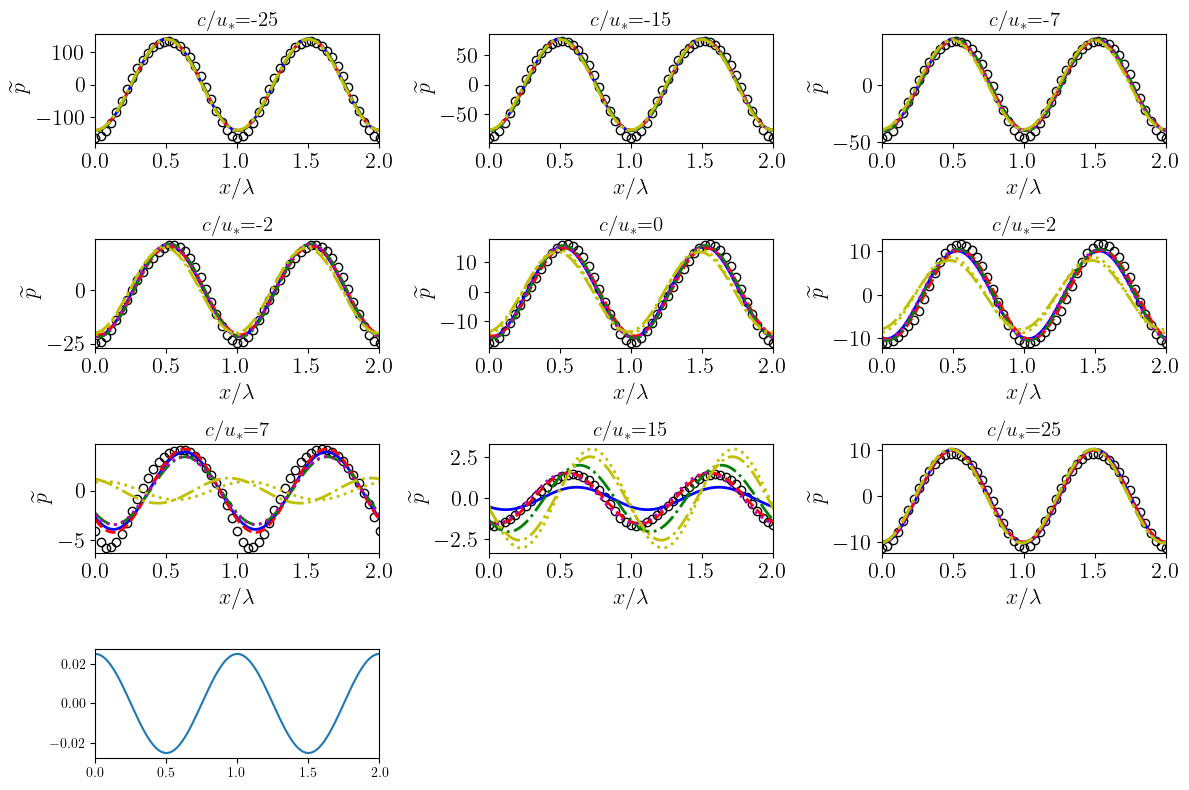

In [14]:
plt.figure(11,figsize=(12,8))
wavelength=2*np.pi/k_wavno
for num_data_select in range(9):
    ax1=plt.subplot(4,3,num_data_select+1)
    phase_diff=np.pi/2*0;
    ax1.plot(x[::2]/wavelength, LES_data[num_data_select].p_w_surf[::2]-np.mean(LES_data[num_data_select].p_w_surf[::2]),'ok',markerfacecolor='none',label='LES')

    for n in n_num_array_index:
        ax1.plot(x/wavelength, 2*Rep[0,3,n,num_data_select]*np.cos(k_wavno*x+phase_diff)*1-1*2*Imp[0,3,n,num_data_select]*np.sin(k_wavno*x+phase_diff),color_array_plot[n],label=r'$2Re\{\hat{p}\}\cos (k\xi)-2Im\{\hat{p}\}\sin (k\xi)$ (TurbCurv)',linewidth=2)
    ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$\widetilde{p}$',fontsize=16)
    ax1.set_xlabel(r'$x/\lambda$',fontsize=16)
    ax1.tick_params(labelsize=16)
    ax1.set_xlim(0,2)
    
ax1=plt.subplot(4,3,10)
ax1.plot(x_LES/wavelength,y)
ax1.set_xlim(0,2)

#plt.savefig('p_surface_WRLES_vs_Model.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)

plt.show()


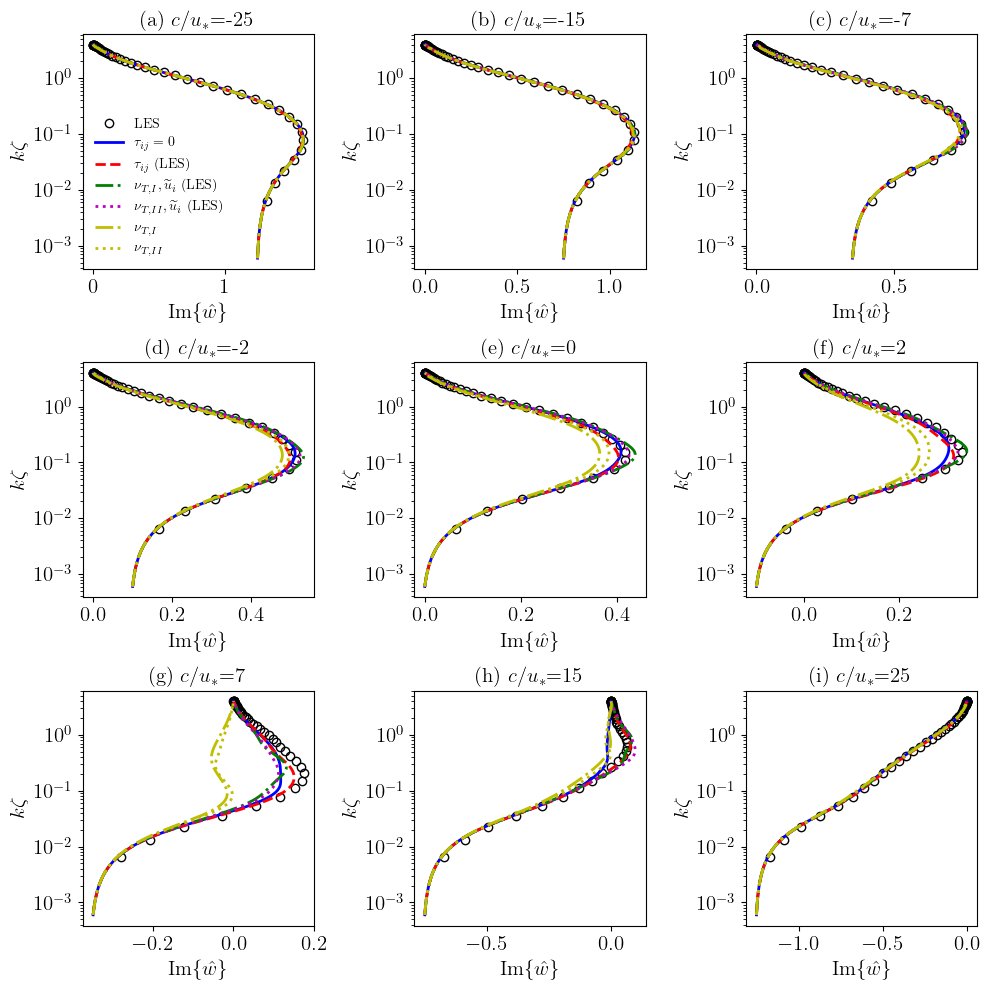

In [15]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='LES')
    
    label_name=['$\\tau_{ij}=0$','$\\tau_{ij}$ (LES)','$\\nu_{T,I}, \\widetilde{u}_i$ (LES)','$\\nu_{T,II}, \\widetilde{u}_i$ (LES)','$\\nu_{T,I}$','$\\nu_{T,II}$']
    for n in n_num_array_index:
        plt.semilogy(Imw[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label=label_name[n],linewidth=2)
    if num_data_select==0:
        ax1.legend(loc="best",frameon=False)
   
    ax1.set_xlabel(r'Im$\{\hat{w}\}$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

#plt.savefig('Imw_profile.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()

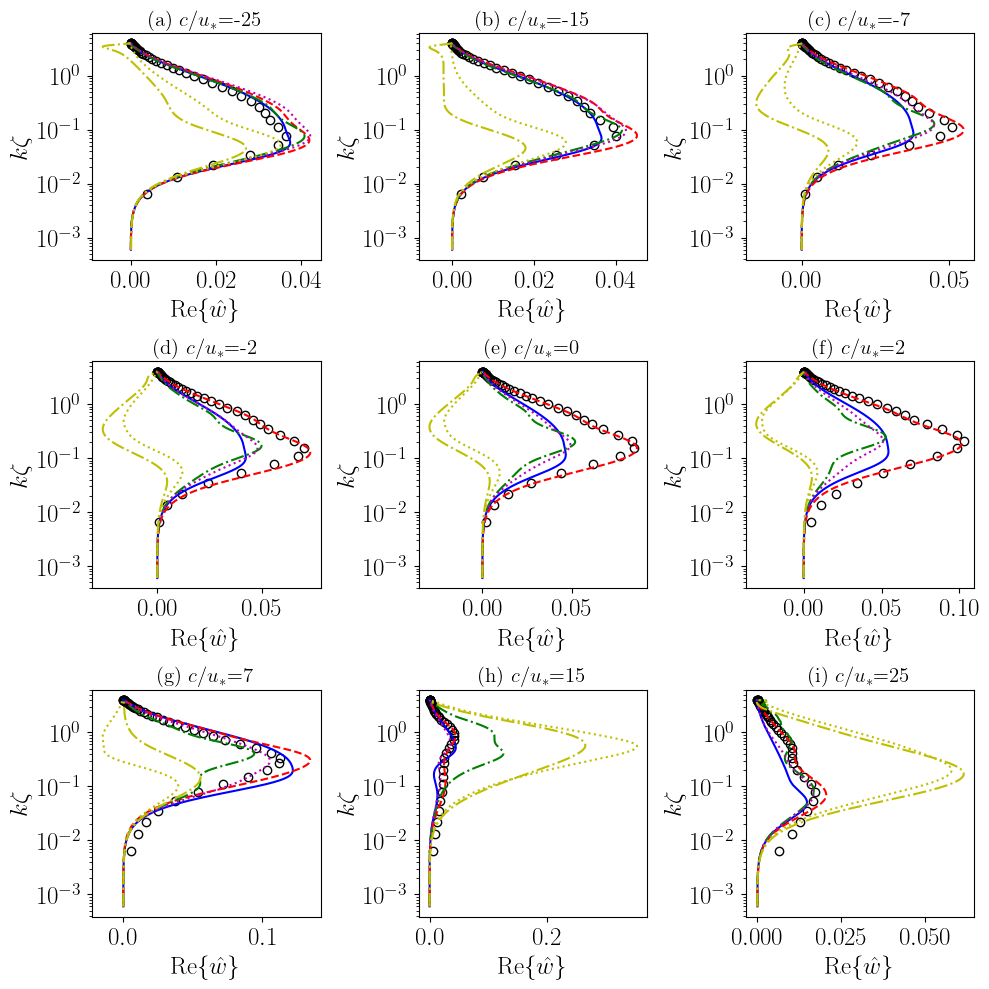

In [16]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    w_LES_data = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    plt.semilogy(w_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='$\Re\{\hat{w}\}$ (LES)')
    
    for n in n_num_array_index:
        plt.semilogy(Rew[:,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n],label='$\Re\{\hat{w}\}$ (Model)')
    
    
    
    ax1.set_xlabel(r'Re$\{\hat{w}\}$',fontsize=18)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=18)
    ax1.tick_params(labelsize=18)

#plt.savefig('Rew_profile.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()


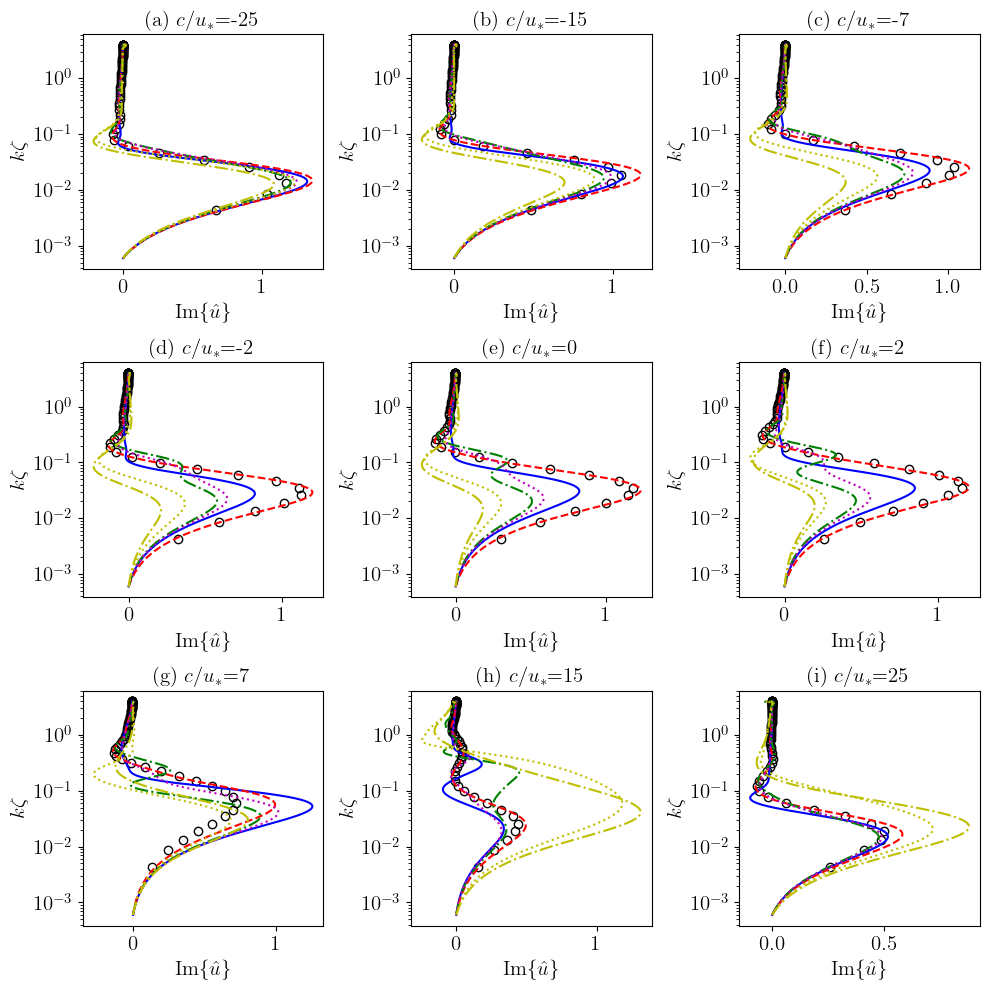

In [17]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,::2].imag,k_wavno*LES_data[num_data_select].zw[::2],'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    #plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')

    
    for n in n_num_array_index:
        plt.semilogy(Imu[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
        #plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    
    
    
    ax1.set_xlabel(r'Im$\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
#plt.savefig('Imu_profile.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()   


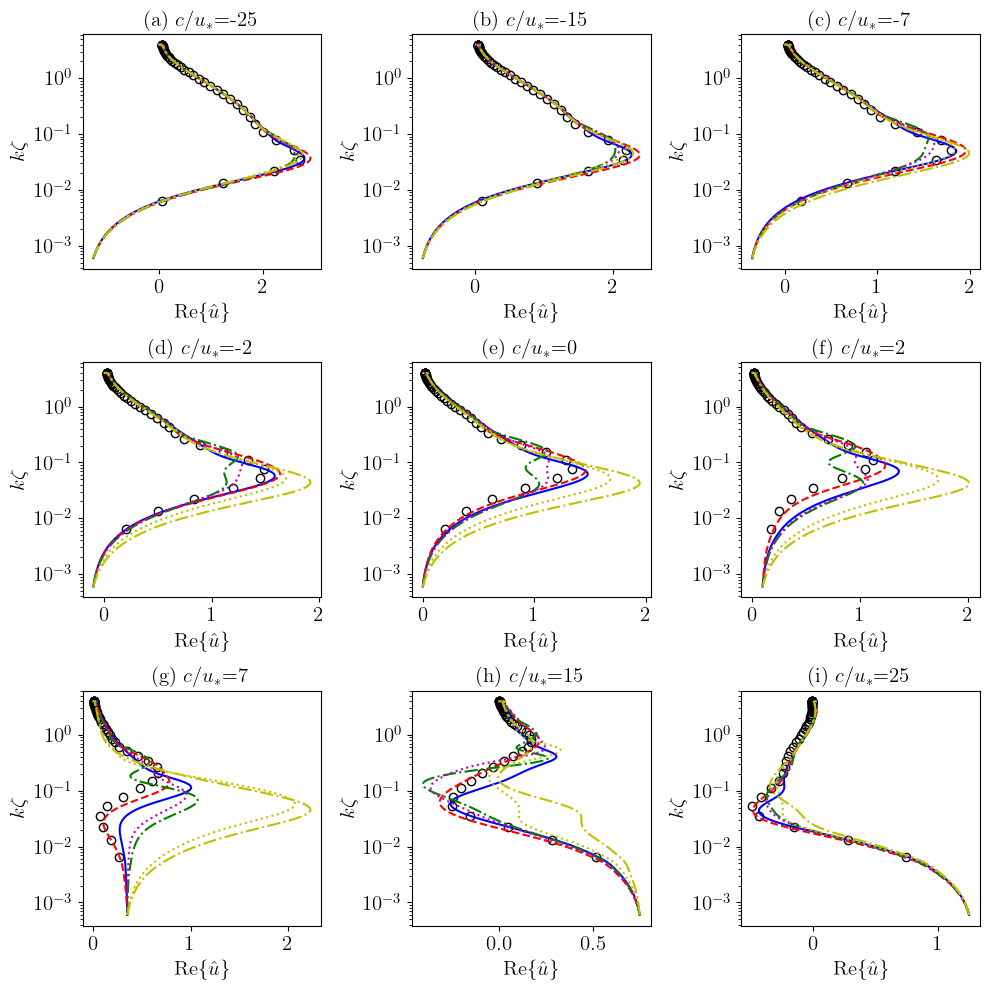

In [18]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    u_LES_data = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    plt.semilogy(u_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')
    #plt.semilogy(w_LES_data[16,:].real,k_wavno*LES_data[num_data_select].zw,'ko',markerfacecolor='none',label='$\Im\{\hat{w}\}$ (LES)')

    
    for n in n_num_array_index:
        plt.semilogy(Reu[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
        #plt.semilogy(Rew[:,n,num_data_select],k_wavno*z,color_array_plot_Im[n],label='$\Im\{\hat{w}\}$ (Model)')
    
    
    
    ax1.set_xlabel(r'Re$\{\hat{u}\}$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
#plt.savefig('Reu_profile.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()



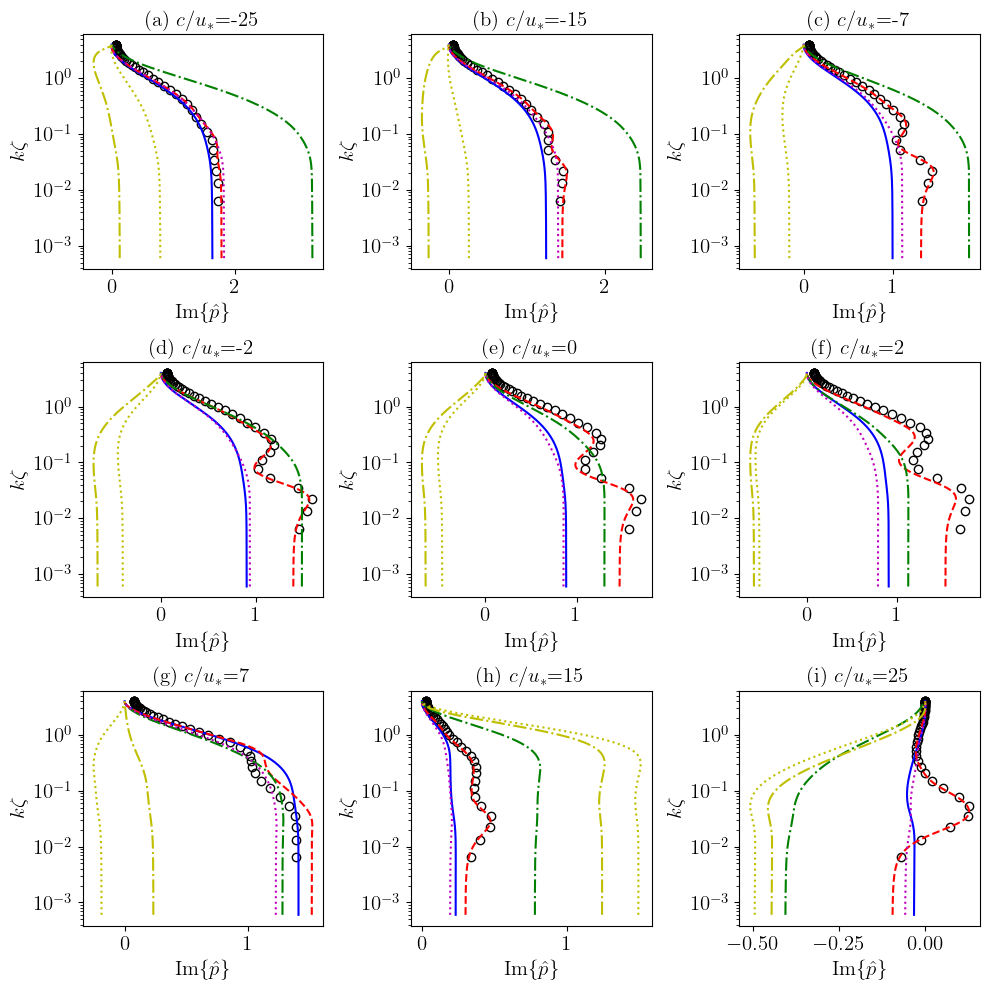

In [19]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,::3].imag,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none')
   
    for n in n_num_array_index:
        plt.semilogy(Imp[:,3,n,num_data_select],k_wavno*z,color_array_plot_Im[n])
        
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'Im$\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)

#plt.savefig('Imp_profile.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()


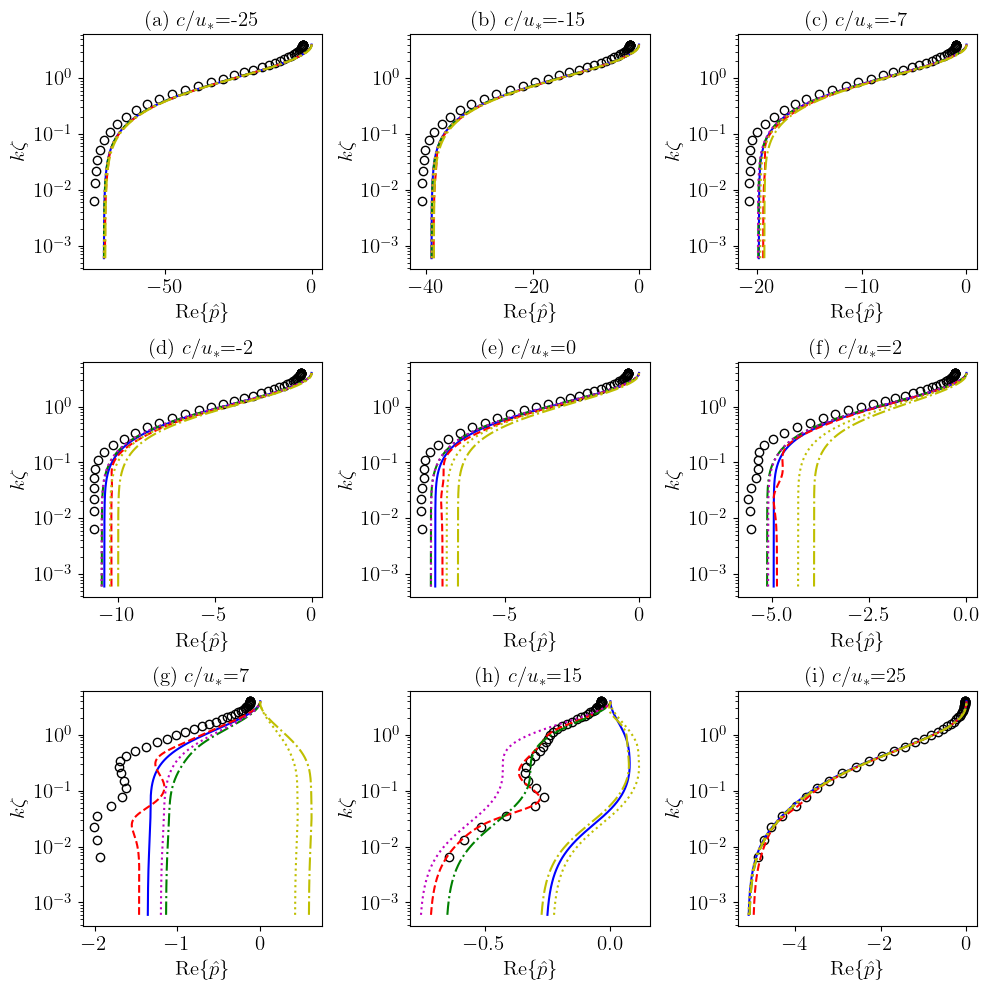

In [20]:
plt.figure(11,figsize=(10,10))

for num_data_select in range(9):
    ax1=plt.subplot(3,3,num_data_select+1)
    
    p_LES_data = np.fft.fft(LES_data[num_data_select].p_w,axis=0,norm='forward')
    #plt.semilogy(p_LES_data[16,:].real,k*LES_data[num_data_select].zw,'ko',markerfacecolor='none')
    plt.semilogy(p_LES_data[16,::3].real,k_wavno*LES_data[num_data_select].zw[::3],'ko',markerfacecolor='none')

    for n in n_num_array_index:
        plt.semilogy(Rep[:,3,n,num_data_select].real,k_wavno*z,color_array_plot_Im[n])
        
    #plt.semilogy(np.abs(p_LES_data[16,:]),k*LES_data[num_data_select].zw,'bv',markerfacecolor='none',label='$|\hat{p}|$ (LES)')
    ax1.set_xlabel(r'Re$\{\hat{p}\}$',fontsize=15)
    ax1.set_title(f'({chr(97 + num_data_select)}) $c/u_*$={c_array[num_data_select]}', fontsize=15)
    ax1.set_ylabel(r'$k\zeta$',fontsize=15)
    ax1.tick_params(labelsize=15)
#plt.savefig('Rep_profile.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()


In [21]:
Rep_interp = np.zeros((Nz,n_num,9),dtype='float')
Imp_interp = np.zeros((Nz,n_num,9),dtype='float')
Reu_interp = np.zeros((Nz,n_num,9),dtype='float')
Imu_interp = np.zeros((Nz,n_num,9),dtype='float')
Rew_interp = np.zeros((Nz,n_num,9),dtype='float')
Imw_interp = np.zeros((Nz,n_num,9),dtype='float')

tau11_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
tau33_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
tau13_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
tau31_hat_model_interp = np.zeros((Nz,n_num,9),dtype='complex')
    
for num_data_select in range(num_data-1): 
    w_hat_LES    = np.fft.fft(LES_data[num_data_select].w,axis=0,norm='forward')
    u_hat_LES    = np.fft.fft(LES_data[num_data_select].u_w,axis=0,norm='forward')
    dwdz_hat_LES = np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    dudz_hat_LES = np.gradient(u_hat_LES[16,:],z_data,edge_order=2)
    z_data       = np.asarray(LES_data[num_data_select].zw).flatten()
    U_data       = np.asarray(LES_data[num_data_select].u_mean).flatten()
    U_prime_LES  = np.gradient(U_data,z_data,edge_order=2)
   
    tau11_hat_LES = np.fft.fft(LES_data[num_data_select].tau11+LES_data[num_data_select].tau11_SGS,axis=0,norm='forward')
    tau33_hat_LES = np.fft.fft(LES_data[num_data_select].tau33+LES_data[num_data_select].tau33_SGS,axis=0,norm='forward')
    tau13_hat_LES = np.fft.fft(LES_data[num_data_select].tau13+LES_data[num_data_select].tau13_SGS,axis=0,norm='forward')
    tau31_hat_LES = np.fft.fft(LES_data[num_data_select].tau31+LES_data[num_data_select].tau31_SGS,axis=0,norm='forward')

    tau11_hat_model_interp[:,1,num_data_select] = tau11_hat_LES[16,:]
    tau33_hat_model_interp[:,1,num_data_select] = tau33_hat_LES[16,:]
    tau13_hat_model_interp[:,1,num_data_select] = tau13_hat_LES[16,:]
    tau31_hat_model_interp[:,1,num_data_select] = tau31_hat_LES[16,:]
    

    #nuT_linear = -tau13_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1])# from LES
    nuT_linear = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)

    tau11_hat_model_interp[:,2,num_data_select] = tau11_hat_model
    tau33_hat_model_interp[:,2,num_data_select] = tau33_hat_model
    tau13_hat_model_interp[:,2,num_data_select] = tau13_hat_model
    tau31_hat_model_interp[:,2,num_data_select] = tau31_hat_model
    
    #nuT_linear_2 = -tau31_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1]) # from LES    
    nuT_linear_2 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    tau11_hat_model_2 = 2*nuT_linear_2*dwdz_hat_LES
    tau13_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear_2*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_2 =   nuT_linear_2*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)

    tau11_hat_model_interp[:,3,num_data_select] = tau11_hat_model_2
    tau33_hat_model_interp[:,3,num_data_select] = tau33_hat_model_2
    tau13_hat_model_interp[:,3,num_data_select] = tau13_hat_model_2
    tau31_hat_model_interp[:,3,num_data_select] = tau31_hat_model_2
    
    for n in range(n_num):
        Rep_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Rep[:,3,n,num_data_select]))
        Rep_interp[0,n,num_data_select]      = np.real(Rep[1,3,n,num_data_select])
        Rep_interp[Nz-1,n,num_data_select]   = np.real(Rep[np.size(z)-3,3,n,num_data_select])
        Imp_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Imp[:,3,n,num_data_select]))
        Imp_interp[0,n,num_data_select]      = np.real(Imp[1,3,n,num_data_select])
        Imp_interp[Nz-1,n,num_data_select]   = np.real(Imp[np.size(z)-3,3,n,num_data_select])


        Reu_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Reu[:,n,num_data_select]))
        Reu_interp[0,n,num_data_select]      = np.real(Reu[1,n,num_data_select])
        Reu_interp[Nz-1,n,num_data_select]   = np.real(Reu[np.size(z)-3,n,num_data_select])
        Imu_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Imu[:,n,num_data_select]))
        Imu_interp[0,n,num_data_select]      = np.real(Imu[1,n,num_data_select])
        Imu_interp[Nz-1,n,num_data_select]   = np.real(Imu[np.size(z)-3,n,num_data_select])

        Rew_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Rew[:,n,num_data_select]))
        Rew_interp[0,n,num_data_select]      = np.real(Rew[1,n,num_data_select])
        Rew_interp[Nz-1,n,num_data_select]   = np.real(Rew[np.size(z)-3,n,num_data_select])
        Imw_interp[1:Nz-1,n,num_data_select] = np.interp(LES_data[num_data_select].zw[1:Nz-1].flatten(),z,np.real(Imw[:,n,num_data_select]))
        Imw_interp[0,n,num_data_select]      = np.real(Imw[1,n,num_data_select])
        Imw_interp[Nz-1,n,num_data_select]   = np.real(Imw[np.size(z)-3,n,num_data_select])


    nuT_linear_3 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))#*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    w_hat_interp = np.real(Rew_interp[:,3,num_data_select])+1j*np.real(Imw_interp[:,3,num_data_select])
    u_hat_interp = np.real(Reu_interp[:,3,num_data_select])+1j*np.real(Imu_interp[:,3,num_data_select])
    dwdz_hat_interp = np.gradient(w_hat_interp,z_data,edge_order=2)
    dudz_hat_interp = np.gradient(u_hat_interp,z_data,edge_order=2)
    
    tau11_hat_model_3 = 2*nuT_linear_3*dwdz_hat_interp
    tau13_hat_model_3 =  -nuT_linear_3*(dudz_hat_interp+1j*k_wavno*w_hat_interp) - nuT_linear_3*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_3 =  -nuT_linear_3*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_3 =   nuT_linear_3*(1j*k_wavno*u_hat_interp-dwdz_hat_interp)

    tau11_hat_model_interp[:,3,num_data_select] = tau11_hat_model_3
    tau33_hat_model_interp[:,3,num_data_select] = tau33_hat_model_3
    tau13_hat_model_interp[:,3,num_data_select] = tau13_hat_model_3
    tau31_hat_model_interp[:,3,num_data_select] = tau31_hat_model_3

    nuT_linear_4 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    w_hat_interp = np.real(Rew_interp[:,4,num_data_select])+1j*np.real(Imw_interp[:,4,num_data_select])
    u_hat_interp = np.real(Reu_interp[:,4,num_data_select])+1j*np.real(Imu_interp[:,4,num_data_select])
    dwdz_hat_interp = np.gradient(w_hat_interp,z_data,edge_order=2)
    dudz_hat_interp = np.gradient(u_hat_interp,z_data,edge_order=2)
    
    tau11_hat_model_4 = 2*nuT_linear_3*dwdz_hat_interp
    tau13_hat_model_4 =  -nuT_linear_3*(dudz_hat_interp+1j*k_wavno*w_hat_interp) - nuT_linear_3*U_prime_LES*(1/zi)*(a/2)
    tau31_hat_model_4 =  -nuT_linear_3*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_4 =   nuT_linear_3*(1j*k_wavno*u_hat_interp-dwdz_hat_interp)

    tau11_hat_model_interp[:,4,num_data_select] = tau11_hat_model_4
    tau33_hat_model_interp[:,4,num_data_select] = tau33_hat_model_4
    tau13_hat_model_interp[:,4,num_data_select] = tau13_hat_model_4
    tau31_hat_model_interp[:,4,num_data_select] = tau31_hat_model_4

    for model_type in range(n_num):
        Rep_interp[0:Nz-1,model_type,num_data_select]     = Rep_interp[0:Nz-1,model_type,num_data_select] -np.real( (1/3)*(tau11_hat_model_interp[0:Nz-1,model_type,num_data_select]+tau33_hat_model_interp[0:Nz-1,model_type,num_data_select]) )
        Imp_interp[0:Nz-1,model_type,num_data_select]     = Imp_interp[0:Nz-1,model_type,num_data_select] -np.imag( (1/3)*(tau11_hat_model_interp[0:Nz-1,model_type,num_data_select]+tau33_hat_model_interp[0:Nz-1,model_type,num_data_select]) )
        
      

/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1299: RuntimeWarning: divide by zero encountered in scalar divide
  b = - (dx2 + dx1) / (dx1 * dx2)
/Users/ghaneshnarasimhan/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1300: RuntimeWarning: divide by zero encountered in scalar divide
  c = (2. * dx2 + dx1) / (dx2 * (dx1 + dx2))
/U

In [22]:
p_induced_model_2D      = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
u_induced_model_2D      = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
w_induced_model_2D      = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau11_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau33_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau13_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')
tau31_induced_model_2D  = np.zeros((Nx,Nz,n_num,num_data-1),dtype='float')

Fp=np.zeros((9,7),dtype='float')#Form drag
detadx=-a*k_wavno*np.sin(k_wavno*x_LES)

for num_data_select in range(num_data-1):
    
    for n in range(n_num):
        for i in range(Nx):
            for k in range(Nz):
                p_induced_model_2D[i,k,n,num_data_select]    = (2*Rep_interp[k,n,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imp_interp[k,n,num_data_select]*np.sin(k_wavno*x_LES[i]))
                u_induced_model_2D[i,k,n,num_data_select]    = (2*Reu_interp[k,n,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imu_interp[k,n,num_data_select]*np.sin(k_wavno*x_LES[i]))
                w_induced_model_2D[i,k,n,num_data_select]    = (2*Rew_interp[k,n,num_data_select]*np.cos(k_wavno*x_LES[i])*1-1*2*Imw_interp[k,n,num_data_select]*np.sin(k_wavno*x_LES[i]))

                Re_tau11 = np.real(tau11_hat_model_interp[:,n,num_data_select])
                Im_tau11 = np.imag(tau11_hat_model_interp[:,n,num_data_select])
                Re_tau33 = np.real(tau33_hat_model_interp[:,n,num_data_select])
                Im_tau33 = np.imag(tau33_hat_model_interp[:,n,num_data_select])
                Re_tau13 = np.real(tau13_hat_model_interp[:,n,num_data_select])
                Im_tau13 = np.imag(tau13_hat_model_interp[:,n,num_data_select])
                Re_tau31 = np.real(tau31_hat_model_interp[:,n,num_data_select])
                Im_tau31 = np.imag(tau31_hat_model_interp[:,n,num_data_select])
                
                
                tau11_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau11[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau11[k]*np.sin(k_wavno*x_LES[i]))
                tau33_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau33[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau33[k]*np.sin(k_wavno*x_LES[i]))
                tau13_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau13[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau13[k]*np.sin(k_wavno*x_LES[i]))
                tau31_induced_model_2D[i,k,n,num_data_select]    = (2*Re_tau31[k]*np.cos(k_wavno*x_LES[i])*1-1*2*Im_tau31[k]*np.sin(k_wavno*x_LES[i]))
    
    
    Fp[num_data_select,0]=(1/wavelength)*np.trapz(LES_data[num_data_select].p_w_surf[0:55]*detadx[0:55],x_LES[0:55])#LES
    Fp[num_data_select,1]=(1/wavelength)*np.trapz(p_induced_model_2D[0:55,0,0,num_data_select]*detadx[0:55],x_LES[0:55])#Visc Curv
    Fp[num_data_select,2]=(1/wavelength)*np.trapz(p_induced_model_2D[0:55,0,1,num_data_select]*detadx[0:55],x_LES[0:55])#Turb Curv with interpolated stress
    Fp[num_data_select,3]=(1/wavelength)*np.trapz(p_induced_model_2D[0:55,0,2,num_data_select]*detadx[0:55],x_LES[0:55])#Turb Curv with nu_{T,I} and u,w from LES
    Fp[num_data_select,4]=(1/wavelength)*np.trapz(p_induced_model_2D[0:55,0,3,num_data_select]*detadx[0:55],x_LES[0:55])#Turb Curv with nu_{T,II} and u,w from LES
    Fp[num_data_select,5]=(1/wavelength)*np.trapz(p_induced_model_2D[0:55,0,4,num_data_select]*detadx[0:55],x_LES[0:55])#Turb Curv with nu_{T,I}
    Fp[num_data_select,6]=(1/wavelength)*np.trapz(p_induced_model_2D[0:55,0,5,num_data_select]*detadx[0:55],x_LES[0:55])#Turb Curv with nu_{T,II}
       
    

In [ ]:
plt.figure(11,figsize=(7,4))
ax1=plt.subplot(1,1,1)

plt.scatter(c_array[0:-1],Fp[:,0],color='k',label='LES')
plt.scatter(c_array[0:-1],Fp[:,1],color='b',marker='*',label='$\\tau_{ij}=0$')
plt.scatter(c_array[0:-1],Fp[:,2],color='r',marker='v',label='$\\tau_{ij}$ (LES)')
plt.scatter(c_array[0:-1],Fp[:,3],color='g',marker='o',label='$\\nu_{T,I} \ \& \ \widetilde{u}_i$ (LES)')
plt.scatter(c_array[0:-1],Fp[:,4],color='m',marker='s',label='$\\nu_{T,II} \ \& \ \widetilde{u}_i$ (LES)')
plt.scatter(c_array[0:-1],Fp[:,5],color='y',marker='o',label='$\\nu_{T,I}$')
plt.scatter(c_array[0:-1],Fp[:,6],color='y',marker='s',label='$\\nu_{T,II}$')

plt.legend(frameon=False,fontsize=10)

plt.plot(c_array[0:-1],Fp[:,0],color='k')
plt.plot(c_array[0:-1],Fp[:,1],color='b',linestyle='-')
plt.plot(c_array[0:-1],Fp[:,2],color='r',linestyle='--')
plt.plot(c_array[0:-1],Fp[:,3],color='g',linestyle='-.')
plt.plot(c_array[0:-1],Fp[:,4],color='m',linestyle=':')
plt.plot(c_array[0:-1],Fp[:,5],color='y',linestyle='-.')
plt.plot(c_array[0:-1],Fp[:,6],color='y',linestyle=':')


ax1.set_xlabel(r'$c/u_*$',fontsize=18)
ax1.set_ylim(-0.1,0.4)
ax1.set_xlim(-30,30)
ax1.set_xticks([-25, -15, -7, -2, 0, 2, 7, 15, 25])
#ax1.set_title(f'$c/u_*$={c_array[num_data_select]}', fontsize=15)
ax1.set_ylabel(r'$F_p$',fontsize=16)
ax1.tick_params(labelsize=16)


#plt.savefig('form_drag.png',format='png',dpi=600,bbox_inches='tight',
#                transparent=False,pad_inches=0.01)
plt.show()

$$ \tau_{ij}^p=J^{-1} p \frac{\partial \xi_j}{\partial x_i}$$

\begin{align*}
\tau_{ij}^p=\begin{bmatrix}
\tau_{11}^p & \tau_{12}^p & \tau_{13}^p\\
\tau_{21}^p & \tau_{22}^p & \tau_{23}^p\\
\tau_{31}^p & \tau_{32}^p & \tau_{33}^p
\end{bmatrix}=
\begin{bmatrix}
p/\zeta_z & 0 & p\zeta_x/\zeta_z\\
0& p/\zeta_z & p\zeta_y/\zeta_z\\
0&0&p
\end{bmatrix}
\end{align*}

In [23]:
taup_11_model = np.zeros((Nx,Nz,n_num,num_data),dtype='float') 
taup_13_model = np.zeros((Nx,Nz,n_num,num_data),dtype='float') 
taup_33_model = np.zeros((Nx,Nz,n_num,num_data),dtype='float') 

for n in range(num_data-1):
    z_data = np.asarray(LES_data[n].zw).flatten()
    g_func = z_data/zi-1
    dgdz_func = 1/zi
    zetaz_J   = np.zeros((Nx,Nz),dtype='float64')
    zetax_J   = np.zeros((Nx,Nz),dtype='float64')
    
    for i in range(Nx):
           for k in range(Nz):
               eta_wave = a*np.cos(k_wavno*x_LES[i])
               eta_x_wave = -a*k_wavno*np.sin(k_wavno*x_LES[i])
               zetaz_J[i,k] = 1/(1-dgdz_func*eta_wave)
               zetax_J[i,k] = g_func[k]*eta_x_wave/(1-dgdz_func*eta_wave)

    for model_type in range(n_num):
        taup_11_model[:,:,model_type,n] = p_induced_model_2D[:,:,model_type,n]/zetaz_J[:,:]
        taup_13_model[:,:,model_type,n] = p_induced_model_2D[:,:,model_type,n]*zetax_J[:,:]/zetaz_J[:,:]
        taup_33_model[:,:,model_type,n] = p_induced_model_2D[:,:,model_type,n]
    
    


In [25]:
#wave-induced energy budget : comparison with eddy viscosity model
tau13_wave_production = np.zeros((Nz,num_data),dtype='float64')
taup_13_production    = np.zeros((Nz,num_data),dtype='float64')
taup_13_production_2    = np.zeros((Nz,num_data),dtype='float64')
taup_13_production_2_model    = np.zeros((Nz,n_num,num_data),dtype='float64')
wave_production_mean  = np.zeros((Nz,num_data),dtype='float64')

wave_to_turbulence_transfer = np.zeros((Nz,num_data),dtype='float64')
wave_viscous_dissipation    = np.zeros((Nz,num_data),dtype='float64')
wave_SGS_dissipation        = np.zeros((Nz,num_data),dtype='float64')


wave_transport                     = np.zeros((Nz,num_data),dtype='float64')
wave_transport_model                     = np.zeros((Nz,n_num,num_data),dtype='float64')

Ew_transport                       = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_tilde_transport     = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_tilde_transport_model     = np.zeros((Nz,n_num,num_data),dtype='float64')

ui_tilde_taup_i3_tilde_transport         = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taup_i3_tilde_transport_model   = np.zeros((Nz,n_num,num_data),dtype='float64')

ui_tilde_taui3_nu_tilde_transport        = np.zeros((Nz,num_data),dtype='float64')
ui_tilde_taui3_nu_tilde_transport_model  = np.zeros((Nz,n_num,num_data),dtype='float64')

ui_tilde_taui3_SGS_tilde_transport       = np.zeros((Nz,num_data),dtype='float64')

for n in range(num_data-1):
    ############################################################################################################################################
    #Wave-induced energy budget
    ############################################################################################################################################
    tau11   = np.zeros((Nx,Nz),dtype='float64')
    tau21   = np.zeros((Nx,Nz),dtype='float64')
    tau31   = np.zeros((Nx,Nz),dtype='float64')
    tau13   = np.zeros((Nx,Nz),dtype='float64')
    tau23   = np.zeros((Nx,Nz),dtype='float64')
    tau33   = np.zeros((Nx,Nz),dtype='float64')
    
    tau11_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau21_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau31_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau13_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau23_tilde  = np.zeros((Nx,Nz),dtype='float64')
    tau33_tilde  = np.zeros((Nx,Nz),dtype='float64')
    
    tau11_mean   = np.zeros((Nz,1),dtype='float64')
    tau21_mean   = np.zeros((Nz,1),dtype='float64')
    tau31_mean   = np.zeros((Nz,1),dtype='float64')
    tau13_mean   = np.zeros((Nz,1),dtype='float64')
    tau23_mean   = np.zeros((Nz,1),dtype='float64')
    tau33_mean   = np.zeros((Nz,1),dtype='float64')
    
    tau11  = LES_data[n].uU_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].U_phase_avg
    tau21  = LES_data[n].vU_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].U_phase_avg
    tau31  = LES_data[n].wU_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].U_phase_avg

    tau13  = LES_data[n].uW_phase_avg - LES_data[n].u_w_phase_avg*LES_data[n].W_phase_avg
    tau23  = LES_data[n].vW_phase_avg - LES_data[n].v_w_phase_avg*LES_data[n].W_phase_avg
    tau33  = LES_data[n].wW_phase_avg -   LES_data[n].w_phase_avg*LES_data[n].W_phase_avg

    #tau11 = tau11 - (1/3)*(tau11+tau33)
    #tau33 = tau33 - (1/3)*(tau11+tau33)
    
    tau11_mean = np.mean(tau11,axis=0)
    tau21_mean = np.mean(tau21,axis=0)
    tau31_mean = np.mean(tau31,axis=0)

    tau13_mean = np.mean(tau13,axis=0)
    tau23_mean = np.mean(tau23,axis=0)
    tau33_mean = np.mean(tau33,axis=0)

    tau11_tilde = tau11 - tau11_mean
    tau21_tilde = tau21 - tau21_mean
    tau31_tilde = tau31 - tau31_mean

    tau13_tilde = tau13 - tau13_mean
    tau23_tilde = tau23 - tau23_mean
    tau33_tilde = tau33 - tau33_mean


    u_tilde      = np.zeros((Nx,Nz),dtype='float64')
    v_tilde      = np.zeros((Nx,Nz),dtype='float64')
    w_tilde      = np.zeros((Nx,Nz),dtype='float64')
    ddx_u_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddx_v_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddx_w_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_u_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_v_tilde  = np.zeros((Nx,Nz),dtype='float64')
    ddz_w_tilde  = np.zeros((Nx,Nz),dtype='float64')
    u_mean_TKE   = np.zeros((Nx,Nz),dtype='float64')


    u_tilde_model      = np.zeros((Nx,Nz,n_num),dtype='float64')
    v_tilde_model      = np.zeros((Nx,Nz,n_num),dtype='float64')
    w_tilde_model      = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddx_u_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddx_v_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddx_w_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddz_u_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddz_v_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    ddz_w_tilde_model  = np.zeros((Nx,Nz,n_num),dtype='float64')
    
    
    u_tilde    = LES_data[n].u_w_phase_avg - np.mean( LES_data[n].u_w_phase_avg,axis=0)
    v_tilde    = LES_data[n].v_w_phase_avg - np.mean( LES_data[n].v_w_phase_avg,axis=0)
    w_tilde    =   LES_data[n].w_phase_avg - np.mean(   LES_data[n].w_phase_avg,axis=0)

    u_mean_TKE = np.mean( LES_data[n].u_w_phase_avg,axis=0)
    dudz_TKE   = np.gradient(u_mean_TKE,z_data,edge_order=2)
    
    for k in range(Nz):
        ddx_u_tilde[:,k] = ddxi_fft(u_tilde[:,k],x_LES,kx)
        ddx_v_tilde[:,k] = ddxi_fft(v_tilde[:,k],x_LES,kx)
        ddx_w_tilde[:,k] = ddxi_fft(w_tilde[:,k],x_LES,kx)


    for i in range(Nx):
        ddz_u_tilde[i,:] = np.gradient(u_tilde[i,:],z_data,edge_order=2)
        ddz_v_tilde[i,:] = np.gradient(v_tilde[i,:],z_data,edge_order=2)
        ddz_w_tilde[i,:] = np.gradient(w_tilde[i,:],z_data,edge_order=2)

    for model_type in range(n_num):
        u_tilde_model[:,:,model_type] = u_induced_model_2D[:,:,model_type,n]
        w_tilde_model[:,:,model_type] = w_induced_model_2D[:,:,model_type,n]
        
        for k in range(Nz):
            ddx_u_tilde_model[:,k,model_type] = ddxi_fft(u_induced_model_2D[:,k,model_type,n],x_LES,kx)
            ddx_w_tilde_model[:,k,model_type] = ddxi_fft(w_induced_model_2D[:,k,model_type,n],x_LES,kx)
        for i in range(Nx):
            ddz_u_tilde_model[i,:,model_type] = np.gradient(u_induced_model_2D[i,:,model_type,n],z_data,edge_order=2)
            ddz_w_tilde_model[i,:,model_type] = np.gradient(w_induced_model_2D[i,:,model_type,n],z_data,edge_order=2)


    #Transport terms
    #wave-induced energy transport
    E_wave  = np.zeros((Nx,Nz),dtype='float')
    W_tilde = np.zeros((Nx,Nz),dtype='float')
    E_wave  = 0.5*(u_tilde*u_tilde+v_tilde*v_tilde+w_tilde*w_tilde)
    W_tilde = LES_data[n].W
    Ew_transport[:,n]=np.gradient(np.mean(E_wave*W_tilde,axis=0),z_data,edge_order=2)

    ############################################################################################################################################

    #wave-induced turbulent transport
    w_hat_LES = np.fft.fft(LES_data[n].w,axis=0,norm='forward')
    u_hat_LES = np.fft.fft(LES_data[n].u_w,axis=0,norm='forward')
    dwdz_hat_LES = np.gradient(w_hat_LES[16,:],z_data,edge_order=2)
    dudz_hat_LES = np.gradient(u_hat_LES[16,:],z_data,edge_order=2)
    
    #tau11_hat_LES = np.fft.fft(LES_data[n].tau11+LES_data[n].tau11_SGS,axis=0,norm='forward')
    #tau33_hat_LES = np.fft.fft(LES_data[n].tau33+LES_data[n].tau33_SGS,axis=0,norm='forward')
    
    #nuT_linear = -tau13_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1])# from LES
    nuT_linear = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))#*np.exp(-5*k_wavno*z_data[0:-1]) # 1*0.41*z_data[0:-1]
    tau11_hat_model = 2*nuT_linear*dwdz_hat_LES
    tau13_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear*dudz_TKE*(1/zi)*(a/2)
    tau31_hat_model =  -nuT_linear*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model =   nuT_linear*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)

    #nuT_linear_2 = -tau31_mean_tot_LES/U_prime_LES*np.exp(-5*k_wavno*z_data[0:-1]) # from LES    
    nuT_linear_2 = ustar*kappa*z_data*(1-np.exp(-z_data*Retau/25))*np.exp(-5*k_wavno*z_data) # 1*0.41*z_data[0:-1]
    tau11_hat_model_2 = 2*nuT_linear_2*dwdz_hat_LES
    tau13_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) - nuT_linear_2*dudz_TKE*(1/zi)*(a/2)
    tau31_hat_model_2 =  -nuT_linear_2*(dudz_hat_LES+1j*k_wavno*w_hat_LES[16,:]) 
    tau33_hat_model_2 =   nuT_linear_2*(1j*k_wavno*u_hat_LES[16,:]-dwdz_hat_LES)
    
    ui_tilde_taui3_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taui3_tilde=u_tilde*tau13_tilde+v_tilde*tau23_tilde+w_tilde*tau33_tilde
    ui_tilde_taui3_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)

    for model_type in range(n_num):
        ui_tilde_taui3_tilde=np.zeros((Nx,Nz),dtype='float')
        ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_induced_model_2D[:,:,model_type,num_data_select] \
                              +w_tilde_model[:,:,model_type]*tau33_induced_model_2D[:,:,model_type,num_data_select]
        
        # if model_type==1:
        #    ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_tilde+w_tilde_model[:,:,model_type]*tau33_tilde
        #    ui_tilde_taui3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)
        # if model_type==2:
        #    ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_hat_model+w_tilde_model[:,:,model_type]*tau33_hat_model
        #    ui_tilde_taui3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)
        # if model_type==3:
        #    ui_tilde_taui3_tilde = u_tilde_model[:,:,model_type]*tau13_hat_model_2+w_tilde_model[:,:,model_type]*tau33_hat_model_2
        #    ui_tilde_taui3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taui3_tilde,axis=0),z_data,edge_order=2)
        
    ############################################################################################################################################

    #wave-induced pressure transport
    taup_11_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_13_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_11_mean  = np.zeros((Nx,Nz),dtype='float')
    taup_13_mean  = np.zeros((Nx,Nz),dtype='float')
    taup_33_tilde = np.zeros((Nx,Nz),dtype='float')
    taup_33_mean  = np.zeros((Nx,Nz),dtype='float')
    
    taup_11_tilde = LES_data[n].taup_11
    taup_13_tilde = LES_data[n].taup_13
    taup_33_tilde = LES_data[n].taup_33
    
    taup_11_mean = LES_data[n].taup_11_mean
    taup_13_mean = LES_data[n].taup_13_mean
    taup_33_mean = LES_data[n].taup_33_mean

    ui_tilde_taup_i3_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taup_i3_tilde=u_tilde*taup_13_tilde + w_tilde*taup_33_tilde
    ui_tilde_taup_i3_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taup_i3_tilde,axis=0),z_data,edge_order=2)

    for model_type in range(n_num):
        ui_tilde_taup_i3_tilde=np.zeros((Nx,Nz),dtype='float')
        ui_tilde_taup_i3_tilde=u_tilde_model[:,:,model_type] *taup_13_model[:,:,model_type,n] + w_tilde_model[:,:,model_type] *taup_33_model[:,:,model_type,n]
        ui_tilde_taup_i3_tilde_transport_model[:,model_type,n] = np.gradient(np.mean(ui_tilde_taup_i3_tilde,axis=0),z_data,edge_order=2)

    
    #wave-induced viscous stress transport    
    tau11_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau21_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau31_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau23_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    tau33_nu_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_nu_mean=np.zeros((Nx,Nz),dtype='float')
    tau23_nu_mean=np.zeros((Nx,Nz),dtype='float')
    tau33_nu_mean=np.zeros((Nx,Nz),dtype='float')

    tau11_nu_tilde = LES_data[n].tau11_nu
    tau21_nu_tilde = LES_data[n].tau21_nu
    tau31_nu_tilde = LES_data[n].tau31_nu
    
    tau13_nu_tilde = LES_data[n].tau13_nu
    tau23_nu_tilde = LES_data[n].tau23_nu
    tau33_nu_tilde = LES_data[n].tau33_nu
    
    tau13_nu_mean = LES_data[n].tau13_nu_mean
    tau23_nu_mean = LES_data[n].tau23_nu_mean
    tau33_nu_mean = LES_data[n].tau33_nu_mean

    ui_tilde_taui3_nu_tilde=np.zeros((Nx,Nz),dtype='float')    
    ui_tilde_taui3_nu_tilde=u_tilde*tau13_nu_tilde+v_tilde*tau23_nu_tilde+w_tilde*tau33_nu_tilde
    ui_tilde_taui3_nu_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_nu_tilde,axis=0),z_data,edge_order=2)

    for model_type in range(n_num):
        ui_tilde_taui3_nu_tilde=np.zeros((Nx,Nz),dtype='float')    
        ui_tilde_taui3_nu_tilde=  u_tilde_model[:,:,model_type]*tau13_nu_tilde \
                                 +v_tilde_model[:,:,model_type]*tau23_nu_tilde \
                                 +w_tilde_model[:,:,model_type]*tau33_nu_tilde
        ui_tilde_taui3_nu_tilde_transport_model[:,model_type,n]=np.gradient(np.mean(ui_tilde_taui3_nu_tilde,axis=0),z_data,edge_order=2)

   
    #wave-induced SGS stress transport   
    tau11_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau21_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau31_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
   
    tau13_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau23_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    tau33_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    
    tau13_SGS_mean=np.zeros((Nx,Nz),dtype='float')
    tau23_SGS_mean=np.zeros((Nx,Nz),dtype='float')
    tau33_SGS_mean=np.zeros((Nx,Nz),dtype='float')

    tau11_SGS_tilde = LES_data[n].tau11_SGS-0*(1/3)*(LES_data[n].tau11_SGS+LES_data[n].tau33_SGS)
    tau21_SGS_tilde = LES_data[n].tau21_SGS
    tau31_SGS_tilde = LES_data[n].tau31_SGS
    tau13_SGS_tilde = LES_data[n].tau13_SGS
    tau23_SGS_tilde = LES_data[n].tau23_SGS
    tau33_SGS_tilde = LES_data[n].tau33_SGS-0*(1/3)*(LES_data[n].tau11_SGS+LES_data[n].tau33_SGS)
    
    tau13_SGS_mean = LES_data[n].tau13_SGS_mean
    tau23_SGS_mean = LES_data[n].tau23_SGS_mean
    tau33_SGS_mean = LES_data[n].tau33_SGS_mean

    ui_tilde_taui3_SGS_tilde=np.zeros((Nx,Nz),dtype='float')
    ui_tilde_taui3_SGS_tilde=u_tilde*tau13_SGS_tilde+v_tilde*tau23_SGS_tilde+w_tilde*tau33_SGS_tilde
    ui_tilde_taui3_SGS_tilde_transport[:,n]=np.gradient(np.mean(ui_tilde_taui3_SGS_tilde,axis=0),z_data,edge_order=2)

    wave_transport[:,n] =    0*Ew_transport[:,n] \
                           + 1*ui_tilde_taui3_tilde_transport[:,n] \
                           + ui_tilde_taup_i3_tilde_transport[:,n] \
                           + ui_tilde_taui3_nu_tilde_transport[:,n] \
                           + 0*ui_tilde_taui3_SGS_tilde_transport[:,n]

    for model_type in range(n_num):
        wave_transport_model[:,model_type, n] =    0*Ew_transport[:,n] \
                                                   + ui_tilde_taui3_tilde_transport_model[:,model_type,n] \
                                                   + ui_tilde_taup_i3_tilde_transport_model[:,model_type,n] \
                                                   + ui_tilde_taui3_nu_tilde_transport_model[:,model_type,n] \
                                                   + 0*ui_tilde_taui3_SGS_tilde_transport[:,n]


    ###################################################################################################################################
    #Production terms
    tau13_wave                 = np.zeros((Nx,Nz),dtype='float')
    tau13_wave_mean            = np.zeros((Nz,1) ,dtype='float')
    
    tau13_wave                 = u_tilde*W_tilde
    tau13_wave_mean            = np.mean(tau13_wave,axis=0)
    tau13_wave_production[:,n] = tau13_wave_mean*dudz_TKE

    taup_13_production_2[:,n]        = -np.mean(  taup_11_tilde*ddx_u_tilde +     0 +     0 \
                                                + taup_13_tilde*ddz_u_tilde +     0 +     taup_33_tilde*ddz_w_tilde, axis=0)

    for model_type in range(n_num):
        taup_13_production_2_model[:,model_type,n] = -np.mean(  taup_11_model[:,:,model_type,n]*ddx_u_tilde_model[:,:,model_type]  +     0 +     0 \
                                                              + taup_13_model[:,:,model_type,n]*ddz_u_tilde_model[:,:,model_type]  +     0    \
                                                              + taup_33_model[:,:,model_type,n]*ddz_w_tilde_model[:,:,model_type] , axis=0)
 

    taup_13_production[:,n]    =  taup_13_mean*dudz_TKE

    wave_production_mean[:,n]        =  tau13_wave_production[:,n] + 0*taup_13_production[:,n]  
    
    wave_to_turbulence_transfer[:,n] = -np.mean(  tau11_tilde*ddx_u_tilde +     tau21_tilde*ddx_v_tilde +     tau31_tilde*ddx_w_tilde \
                                                + tau13_tilde*ddz_u_tilde +     tau23_tilde*ddz_v_tilde +     tau33_tilde*ddz_w_tilde, axis=0)
    
    wave_viscous_dissipation[:,n]    = -np.mean(  tau11_nu_tilde*ddx_u_tilde +     tau21_nu_tilde*ddx_v_tilde +     tau31_nu_tilde*ddx_w_tilde \
                                                + tau13_nu_tilde*ddz_u_tilde +     tau23_nu_tilde*ddz_v_tilde +     tau33_nu_tilde*ddz_w_tilde, axis=0)
    
    wave_SGS_dissipation[:,n]        = -np.mean(  tau11_SGS_tilde*ddx_u_tilde +     tau21_SGS_tilde*ddx_v_tilde +     tau31_SGS_tilde*ddx_w_tilde \
                                                + tau13_SGS_tilde*ddz_u_tilde +     tau23_SGS_tilde*ddz_v_tilde +     tau33_SGS_tilde*ddz_w_tilde, axis=0)

    

0
1
2
3
4
5
6
7
8
8 legend


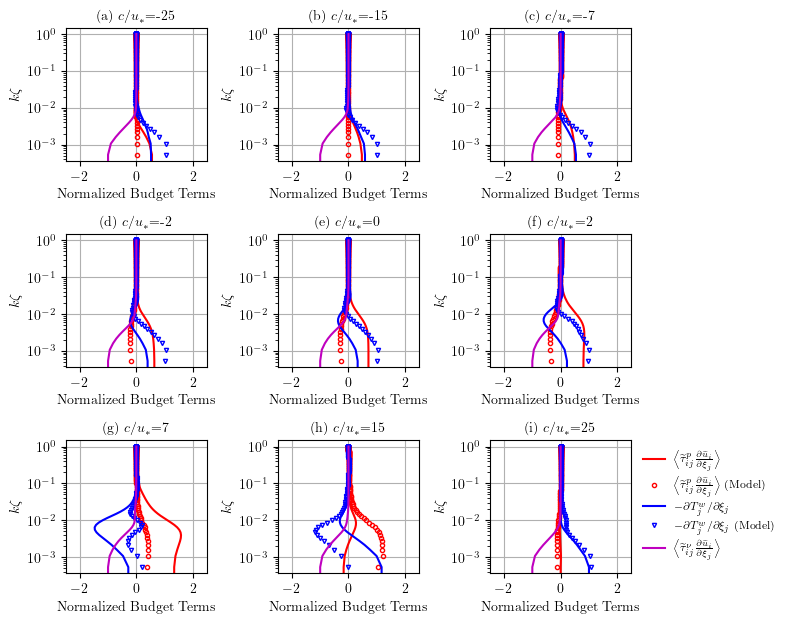

In [26]:
plt.figure(18,figsize=(8,8))
font_size=10
power_norm=0
model_type=4
for n in range(num_data-1):
    if n<num_data-1:
        print(n)
        ax1=plt.subplot(4,3,n+1)
        ax1.set_title(f'({chr(97 + n)}) $c/u_*$={c_array[n]}', fontsize=font_size)
    else:
        print(n,num_data)
        ax1=plt.subplot(4,3,n+2)
        ax1.set_title(f'({chr(97 + n)}) Flat wall', fontsize=font_size)
    
    normalisation=np.abs(1/wave_viscous_dissipation[0,n])
    
    
    #plt.semilogy(-normalisation*wave_production_mean[:,n],linestyle='--',z_data,color='r',label=r'$-\langle\tau_{ij}^w\rangle\frac{\partial \langle u_i\rangle}{\partial \xi_j}$')

    plt.semilogy(-normalisation*taup_13_production_2[:,n],z_data,color='r',linestyle='-',label=r'$\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    plt.semilogy(-normalisation*taup_13_production_2_model[0:-1,model_type,n],z_data[0:-1],color='r',marker='o',markersize=3,markerfacecolor='none',linestyle='none',label=r'$\left\langle\widetilde{\tau}_{ij}^{p}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$ (Model)')
    
    plt.semilogy(-normalisation*wave_transport[:,n],z_data,color='b',label=r'$-{\partial T^w_j}/{\partial \xi_j}$')
    plt.semilogy(-normalisation*wave_transport_model[0:-1,model_type,n],z_data[0:-1],color='b',marker='v',markersize=3,markerfacecolor='none',linestyle='none',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (Model)')

    #plt.semilogy(-normalisation* ui_tilde_taup_i3_tilde_transport_model[:,1,n],z_data,color='c',linestyle='--',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
    #plt.semilogy(-normalisation* ui_tilde_taup_i3_tilde_transport[:,n],z_data,color='b',linestyle='--',label=r'$-{\partial T^w_j}/{\partial \xi_j}$ (visc)')
   
    
    plt.semilogy(-normalisation*wave_viscous_dissipation[:,n],z_data,color='m',label=r'$\left\langle\widetilde{\tau}_{ij}^\nu\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    
    
    #plt.semilogy(-normalisation*wave_to_turbulence_transfer[:,n],z_data,color='k',label=r'$\left\langle\widetilde{\tau}_{ij}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    #plt.semilogy(-normalisation*wave_SGS_dissipation[:,n],z_data,color='c',label=r'$\left\langle\widetilde{\tau}_{ij}^{\mathrm{SGS}}\frac{\partial\widetilde{u}_i}{\partial \xi_j}\right\rangle$')
    
    # plt.semilogy(normalisation*(-0*wave_production_mean[:,n] \
    #              -taup_13_production_2[:,n] \
    #              -wave_transport[:,n] \
    #              -0*wave_to_turbulence_transfer[:,n] \
    #              -wave_viscous_dissipation[:,n] \
    #              -0*wave_SGS_dissipation[:,n]),z_data,color='c',linestyle='-',label='total')

    # plt.semilogy(normalisation*(-0*wave_production_mean[0:-1,n] \
    #              -taup_13_production_2_model[0:-1,model_type,n] \
    #              -wave_transport_model[0:-1,model_type,n] \
    #              -0*wave_to_turbulence_transfer[0:-1,n] \
    #              -wave_viscous_dissipation[0:-1,n] \
    #              -0*wave_SGS_dissipation[0:-1,n]),z_data[0:-1],color='k',linestyle='--',label='total (Model)')

   
    if n==num_data-2:
        print(n,'legend')
        plt.legend(bbox_to_anchor=[1.01, 1], fontsize=8, frameon=False)
    
        
    plt.grid(True)
    ax1.tick_params(labelsize=font_size)
    
   # ax1.set_xlim(-np.abs((wave_viscous_dissipation[0,n]))-100,np.abs((wave_viscous_dissipation[0,n]))+100)
   # ax1.set_xticks([normalisation*(np.round(-np.abs((wave_viscous_dissipation[0,n])))-10),0,normalisation*(10+np.round(np.abs((wave_viscous_dissipation[0,n]))))] )
    ax1.set_xlim(-2.5,2.5)
   # ax1.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5] )
    
    ax1.set_ylabel('$k \zeta$',fontsize=font_size)
    ax1.set_xlabel('Normalized Budget Terms',fontsize=font_size)

#plt.savefig('wave_energy_budget.png',format='png',dpi=600,bbox_inches='tight',
#            transparent=False,pad_inches=0.01)

    
plt.show()